In [1]:
import tensorflow as tf

2024-01-23 22:21:13.487822: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-23 22:22:26.039936: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import wrapt
wrapt.__version__   # should be 1.14.1

'1.14.1'

In [3]:
from tensorflow import keras as keras
from keras import layers as layers

In [4]:
import os, timeit
from skimage.filters import threshold_otsu
import numpy as np
from math import inf as inf

In [5]:
import pandas as pd

In [6]:
from spectral.io import envi as envi
from spectral import imshow

In [7]:
from sklearn.decomposition import IncrementalPCA

In [8]:
import sys

In [9]:
import random

tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

In [10]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(physical_devices[1], 'GPU')

Num GPUs Available:  2


In [11]:
from sys import platform
DATA_DIRECTORY = ""
SLASH = ""
if platform == "linux" or platform == "linux2":
    DATA_DIRECTORY = "/home/tyagi/Desktop/wheat/data/BULK/"
    SLASH = "/"
elif platform == "win32":
    DATA_DIRECTORY = "D:\wheat\data\BULK\\"
    SLASH="\\"

In [12]:
#Constants
BAND_NUMBER = 60
FILLED_AREA_RATIO = 0.9
TRAIN_IMAGE_COUNT = 1200
VAL_IMAGE_COUNT = 400
TEST_IMAGE_COUNT = 400
NUM_VARIETIES = 4

IMAGE_WIDTH = 30
IMAGE_HEIGHT = 30

In [13]:
ACTIVATION_TYPE =  "relu"
BATCH_SIZE = 64

LEARNING_RATE_BASE = 0.0001

In [14]:
from enum import Enum

class filter_method(Enum):
    none = 0
    snv = 1
    msc = 2
    savgol = 3
    
FILTER = filter_method(2).name

# to be set if filter chosen is savgol
WINDOW = 7
ORDER = 2
DERIVATIVE = "none"

In [15]:
from enum import Enum
 
class feature_extraction_method(Enum):
    none = 0
    pca_loading = 1
    lda = 2
    ipca = 3

FEATURE_EXTRACTION = feature_extraction_method(0).name

NUM_OF_BANDS = 3
if FEATURE_EXTRACTION == "pca_loading" or FEATURE_EXTRACTION == "ipca":
    NUM_OF_BANDS = 8
elif FEATURE_EXTRACTION == "lda":
    NUM_OF_BANDS = 3
    assert NUM_OF_BANDS <= min(NUM_VARIETIES-1,168),"NUM_OF_BANDS is greater."


REMOVE_NOISY_BANDS = False
FIRST_BAND = 15
LAST_BAND = 161

In [16]:
def start_timer():
    print("Testing started")
    return timeit.default_timer()

def end_timer():
    return timeit.default_timer()

def show_time(tic,toc): 
    test_time = toc - tic
    print('Testing time (s) = ' + str(test_time) + '\n')

In [17]:
# List for All varieties
VARIETIES = []
VARIETIES_CODE = {}

for name in os.listdir(DATA_DIRECTORY):
    if (name.endswith(".hdr") or name.endswith(".bil")):
        continue
    VARIETIES_CODE[name] = len(VARIETIES)
    VARIETIES.append(name)
    if len(VARIETIES)==NUM_VARIETIES:
        break

In [18]:
def dataset_file_name(variety):
    name = "./dataset/V"+str(variety).zfill(3)+"_FilledArea_"+str(FILLED_AREA_RATIO)+"_NumOfBands_"+str(NUM_OF_BANDS)+"_FB_"+str(FIRST_BAND)+"_LB_"+str(LAST_BAND)+"_BandNo_"+str(BAND_NUMBER)+"_ImageHeight_"+str(IMAGE_HEIGHT)+"_ImageWidth_"+str(IMAGE_WIDTH)+"_FILTER_"+str(FILTER)+"_FeatureExtraction_"+str(FEATURE_EXTRACTION)
    if REMOVE_NOISY_BANDS:
        name+="_REMOVE_NOISY_BANDS_"+str(REMOVE_NOISY_BANDS)
    if FILTER == "savgol":
        name+="_WINDOW_"+str(WINDOW)+"_ORDER_"+str(ORDER)
    return name

In [19]:
x_train = []
y_train = []
x_val = []
y_val = []
test_dataset=[]
test_dataset_label = []

for idx, v in enumerate(VARIETIES):
    print("idx: ",idx)
    if idx >= NUM_VARIETIES:
        break
    x_train= x_train + np.load(dataset_file_name(v)+"_train_dataset.npy").tolist()
    y_train = y_train + np.load(dataset_file_name(v)+"_train_dataset_label.npy").tolist()
    x_val= x_val + np.load(dataset_file_name(v)+"_val_dataset.npy").tolist()
    y_val = y_val + np.load(dataset_file_name(v)+"_val_dataset_label.npy").tolist()
    test_dataset = test_dataset + np.load(dataset_file_name(v)+"_test_dataset.npy").tolist()
    test_dataset_label = test_dataset_label + np.load(dataset_file_name(v)+"_test_dataset_label.npy").tolist()
    
x_train = np.array(x_train)
y_train = np.array(y_train)
x_val = np.array(x_val)
y_val = np.array(y_val)
test_dataset = np.array(test_dataset)
test_dataset_label = np.array(test_dataset_label)

idx:  0
idx:  1
idx:  2
idx:  3


In [20]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses, Model
from keras.layers import Input, Conv2D, MaxPool2D, MaxPooling2D, Activation, Flatten, Dense, AveragePooling2D, GlobalAveragePooling2D
from keras.layers import Dropout
from keras.optimizers import Adam

In [21]:
def normalizeDataWholeSeed(data,normalization_type='max'):
    
    if normalization_type == 'max':
        for idx in range(data.shape[0]):
            data[idx,:,:,:] = data[idx,:,:,:]/np.max(abs(data[idx,:,:,:]))
            
    elif normalization_type == 'l2norm':
        from numpy import linalg as LA
        for idx in range(data.shape[0]):
            data[idx,:,:,:] = data[idx,:,:,:]/LA.norm(data[idx,:,:,:])       
        
    return data

In [22]:
def inception(x,filters_1x1,filters_3x3_reduce,filters_3x3,filters_5x5_reduce,filters_5x5,filters_pool,activation_type='relu'):
    path1 = Conv2D(filters_1x1,        (1, 1), padding='same', activation=activation_type)(x)
    
    path2 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation=activation_type)(x)
    path2 = Conv2D(filters_3x3,        (1, 1), padding='same', activation=activation_type)(path2)
    
    path3 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation=activation_type)(x)
    path3 = Conv2D(filters_5x5,        (1, 1), padding='same', activation=activation_type)(path3)
    
    path4 = MaxPool2D((3, 3),  strides=(1, 1), padding='same')(x)
    path4 = Conv2D(filters_pool,       (1, 1), padding='same', activation=activation_type)(path4)
    
    return tf.concat([path1, path2, path3, path4], axis=3)

In [23]:
def auxiliary_classifier(x,num_classes,activation_type='relu'):
    aux = AveragePooling2D((5, 5), strides=3)(x)
    aux = Conv2D(128, 1, padding='same', activation=activation_type)(aux)
    aux = Flatten()(aux)
    aux = Dense(1024, activation=activation_type)(aux)
    aux = Dropout(0.7)(aux)
    aux = Dense(num_classes, activation='softmax')(aux)
    return aux

In [24]:
def GoogleNetModel(data_num_rows, data_num_cols, num_input_chans=1, num_classes=NUM_VARIETIES, activation_type='relu', dropout_rate=0.0):

    inp = Input(shape=(data_num_rows, data_num_cols, num_input_chans))
    input_tensor = layers.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear", input_shape=x_train.shape[1:])(inp)
    x = Conv2D(64,  7, strides=2, padding='same', activation=activation_type)(input_tensor)
    x = MaxPooling2D(3, strides=2)(x)
    x = Conv2D(64,  1, strides=1, padding='same', activation=activation_type)(x)
    x = Conv2D(192, 3, strides=1, padding='same', activation=activation_type)(x)
    x = MaxPooling2D(3, strides=2)(x)
    x = inception(x, filters_1x1=64 , filters_3x3_reduce=96 , filters_3x3=128, filters_5x5_reduce=16, filters_5x5=32, filters_pool=32)
    x = inception(x, filters_1x1=128, filters_3x3_reduce=128, filters_3x3=192, filters_5x5_reduce=32, filters_5x5=96, filters_pool=64)
    x = MaxPooling2D(3, strides=2)(x)
    x = inception(x, filters_1x1=192, filters_3x3_reduce=96 , filters_3x3=208, filters_5x5_reduce=16, filters_5x5=48, filters_pool=64)
    aux1 = auxiliary_classifier(x,num_classes)
    
    x = inception(x, filters_1x1=160, filters_3x3_reduce=112, filters_3x3=224, filters_5x5_reduce=24, filters_5x5=64, filters_pool=64)
    x = inception(x, filters_1x1=128, filters_3x3_reduce=128, filters_3x3=256, filters_5x5_reduce=24, filters_5x5=64, filters_pool=64)
    x = inception(x, filters_1x1=112, filters_3x3_reduce=144, filters_3x3=288, filters_5x5_reduce=32, filters_5x5=64, filters_pool=64)
    
    aux2 = auxiliary_classifier(x,num_classes)
    
    x = inception(x, filters_1x1=256, filters_3x3_reduce=160, filters_3x3=320, filters_5x5_reduce=32, filters_5x5=128, filters_pool=128)
    x = MaxPooling2D(3, strides=2)(x)
    x = inception(x, filters_1x1=256, filters_3x3_reduce=160, filters_3x3=320, filters_5x5_reduce=32, filters_5x5=128, filters_pool=128)
    x = inception(x, filters_1x1=384, filters_3x3_reduce=192, filters_3x3=384, filters_5x5_reduce=48, filters_5x5=128, filters_pool=128)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout_rate)(x)
    out = Dense(num_classes, activation='softmax')(x)
    
    return Model(inputs = inp, outputs = [out, aux1, aux2])

In [25]:
def getGoogleNetModel():
    learning_rate_base = LEARNING_RATE_BASE
    activation_type = ACTIVATION_TYPE
    wheat_types =  VARIETIES
    num_classes = len(wheat_types)
    dropout_rate = 0.4
    print("--------------Load Data--------------")

    x_training = np.array(x_train)
    labels_training = np.array(y_train)
    
    # Normalize the data
    x_training = normalizeDataWholeSeed(x_training)
    
    # Extract some information
    num_train = x_training.shape[0]
    N_spatial = x_training.shape[1:3]
    N_channel = x_training.shape[3]
    
    print("--------------Done--------------")
    
    ############ Create a model ############
    print("--------------Create a model--------------")
    
    # Generate a model
    model = GoogleNetModel(data_num_rows = N_spatial[0], 
                           data_num_cols = N_spatial[1],
                           num_input_chans = N_channel, 
                           num_classes = num_classes,
                           activation_type = activation_type,
                           dropout_rate = dropout_rate)

    # Compile the model
    adam_opt = Adam(learning_rate=LEARNING_RATE_BASE, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(optimizer=adam_opt, loss=[losses.sparse_categorical_crossentropy,losses.sparse_categorical_crossentropy,losses.sparse_categorical_crossentropy],loss_weights=[1, 0.3, 0.3],metrics=['accuracy'])
    print("---------Completed---------")
    return model

In [26]:
def plot_graph(df,title,xlabel,ylabel,values=['loss'],legends=[]):
    
    for value in values:
        epoch_count = range(1, len(df.index) + 1)
        plt.plot(epoch_count, df[value].tolist())
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    if legends==[]:
        legends = values
    plt.legend(legends, loc='upper left')
    plt.show()

In [27]:
y_train = [y_train,y_train,y_train]
y_val = [y_val,y_val,y_val]

In [28]:
import pandas as pd
import os

def save_to_csv(file_path, data_frame, header=False):
    file_exists = os.path.exists(file_path)

    if not file_exists or not header:
        data_frame.to_csv(file_path, index=False, mode='w')
    else:
        data_frame.to_csv(file_path, index=False, mode='a', header=False)

In [29]:
VARIETIES

['HD 3086', 'PBW 291', 'DBW 187', 'DBW222']

In [30]:
model = None

In [31]:
start_epoch = 1

In [32]:
model_name = "GN_"+"_IC_"+str(TRAIN_IMAGE_COUNT).zfill(5)+"_FilledArea_"+str(FILLED_AREA_RATIO)+"_BandNo_"+str(BAND_NUMBER)+"_ImageHeight_"+str(IMAGE_HEIGHT)+"_ImageWidth_"+str(IMAGE_WIDTH)+"_FILTER_"+str(FILTER)+"_FeatureExtraction_"+str(FEATURE_EXTRACTION)
if REMOVE_NOISY_BANDS:
    model_name+="_REMOVE_NOISY_BANDS_"+str(REMOVE_NOISY_BANDS)+"_NumOfBands_"+str(NUM_OF_BANDS)+"_FB_"+str(FIRST_BAND)+"_LB_"+str(LAST_BAND)
if FILTER == "savgol":
    model_name+="_WINDOW_"+str(WINDOW)+"_ORDER_"+str(ORDER)

if start_epoch != 1:
    model = tf.keras.models.load_model('./GNmodels/'+str(start_epoch-1)+model_name)
else:
    model = getGoogleNetModel()

--------------Load Data--------------
--------------Done--------------
--------------Create a model--------------


2024-01-23 22:34:32.173224: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15016 MB memory:  -> device: 1, name: Quadro P5000, pci bus id: 0000:9b:00.0, compute capability: 6.1


---------Completed---------


In [33]:
last_epoch = 100

In [34]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 30, 30, 168  0           []                               
                                )]                                                                
                                                                                                  
 resizing (Resizing)            (None, 224, 224, 16  0           ['input_1[0][0]']                
                                8)                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  526912      ['resizing[0][0]']               
                                )                                                             

 max_pooling2d_6 (MaxPooling2D)  (None, 13, 13, 512)  0          ['tf.concat_2[0][0]']            
                                                                                                  
 conv2d_22 (Conv2D)             (None, 13, 13, 160)  82080       ['tf.concat_2[0][0]']            
                                                                                                  
 conv2d_24 (Conv2D)             (None, 13, 13, 224)  25312       ['conv2d_23[0][0]']              
                                                                                                  
 conv2d_26 (Conv2D)             (None, 13, 13, 64)   1600        ['conv2d_25[0][0]']              
                                                                                                  
 conv2d_27 (Conv2D)             (None, 13, 13, 64)   32832       ['max_pooling2d_6[0][0]']        
                                                                                                  
 tf.concat

                                                                                                  
 conv2d_49 (Conv2D)             (None, 6, 6, 320)    51520       ['conv2d_48[0][0]']              
                                                                                                  
 conv2d_51 (Conv2D)             (None, 6, 6, 128)    4224        ['conv2d_50[0][0]']              
                                                                                                  
 conv2d_52 (Conv2D)             (None, 6, 6, 128)    106624      ['max_pooling2d_11[0][0]']       
                                                                                                  
 tf.concat_7 (TFOpLambda)       (None, 6, 6, 832)    0           ['conv2d_47[0][0]',              
                                                                  'conv2d_49[0][0]',              
                                                                  'conv2d_51[0][0]',              
          

In [35]:
tic = start_timer()
while start_epoch<=last_epoch:
    print("\nEpoch: ",start_epoch)
    history = model.fit(x_train ,y_train ,batch_size=BATCH_SIZE ,epochs=1, verbose=2, validation_data=(x_val, y_val), shuffle=True)
    model.save('./GNmodels/'+str(start_epoch)+model_name)
    print("Model saved on epoch: ",start_epoch)
    
    history_dataframe = pd.DataFrame.from_dict(history.history)
    save_to_csv('./csvs/'+model_name+'.csv', history_dataframe, header=True)
    print("added to csv")
    start_epoch+=1
    
toc = end_timer()
show_time(tic,toc)

Testing started

Epoch:  1


2024-01-23 22:34:50.269134: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8907


75/75 - 78s - loss: 2.0895 - dense_4_loss: 1.3038 - dense_1_loss: 1.3099 - dense_3_loss: 1.3093 - dense_4_accuracy: 0.3325 - dense_1_accuracy: 0.3427 - dense_3_accuracy: 0.3450 - val_loss: 1.8422 - val_dense_4_loss: 1.1434 - val_dense_1_loss: 1.1695 - val_dense_3_loss: 1.1599 - val_dense_4_accuracy: 0.4525 - val_dense_1_accuracy: 0.4512 - val_dense_3_accuracy: 0.4606 - 78s/epoch - 1s/step


2024-01-23 22:36:03.142962: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 22:36:03.152712: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 22:36:03.161362: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 22

INFO:tensorflow:Assets written to: ./GNmodels/1GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  1
added to csv

Epoch:  2
75/75 - 48s - loss: 1.7924 - dense_4_loss: 1.1097 - dense_1_loss: 1.1409 - dense_3_loss: 1.1346 - dense_4_accuracy: 0.4650 - dense_1_accuracy: 0.4519 - dense_3_accuracy: 0.4508 - val_loss: 1.7614 - val_dense_4_loss: 1.0952 - val_dense_1_loss: 1.1117 - val_dense_3_loss: 1.1090 - val_dense_4_accuracy: 0.5119 - val_dense_1_accuracy: 0.5050 - val_dense_3_accuracy: 0.4931 - 48s/epoch - 635ms/step


2024-01-23 22:37:07.029743: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 22:37:07.039191: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 22:37:07.047580: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 22

INFO:tensorflow:Assets written to: ./GNmodels/2GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  2
added to csv

Epoch:  3
75/75 - 47s - loss: 1.6731 - dense_4_loss: 1.0286 - dense_1_loss: 1.0792 - dense_3_loss: 1.0692 - dense_4_accuracy: 0.5088 - dense_1_accuracy: 0.4858 - dense_3_accuracy: 0.4767 - val_loss: 1.6463 - val_dense_4_loss: 1.0102 - val_dense_1_loss: 1.0638 - val_dense_3_loss: 1.0563 - val_dense_4_accuracy: 0.5825 - val_dense_1_accuracy: 0.5306 - val_dense_3_accuracy: 0.5412 - 47s/epoch - 633ms/step


2024-01-23 22:38:10.514671: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 22:38:10.523723: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 22:38:10.531831: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 22

INFO:tensorflow:Assets written to: ./GNmodels/3GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/3GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  3
added to csv

Epoch:  4
75/75 - 48s - loss: 1.6110 - dense_4_loss: 0.9921 - dense_1_loss: 1.0313 - dense_3_loss: 1.0317 - dense_4_accuracy: 0.5381 - dense_1_accuracy: 0.5321 - dense_3_accuracy: 0.5200 - val_loss: 1.5573 - val_dense_4_loss: 0.9528 - val_dense_1_loss: 1.0071 - val_dense_3_loss: 1.0078 - val_dense_4_accuracy: 0.6150 - val_dense_1_accuracy: 0.5763 - val_dense_3_accuracy: 0.5763 - 48s/epoch - 634ms/step


2024-01-23 22:39:13.497142: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 22:39:13.506098: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 22:39:13.514325: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 22

INFO:tensorflow:Assets written to: ./GNmodels/4GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/4GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  4
added to csv

Epoch:  5
75/75 - 48s - loss: 1.4945 - dense_4_loss: 0.9201 - dense_1_loss: 0.9560 - dense_3_loss: 0.9586 - dense_4_accuracy: 0.5844 - dense_1_accuracy: 0.5804 - dense_3_accuracy: 0.5838 - val_loss: 1.4012 - val_dense_4_loss: 0.8461 - val_dense_1_loss: 0.9350 - val_dense_3_loss: 0.9154 - val_dense_4_accuracy: 0.6550 - val_dense_1_accuracy: 0.6056 - val_dense_3_accuracy: 0.6162 - 48s/epoch - 636ms/step


2024-01-23 22:40:17.153419: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 22:40:17.162541: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 22:40:17.170728: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 22

INFO:tensorflow:Assets written to: ./GNmodels/5GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/5GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  5
added to csv

Epoch:  6
75/75 - 48s - loss: 1.2755 - dense_4_loss: 0.7677 - dense_1_loss: 0.8549 - dense_3_loss: 0.8380 - dense_4_accuracy: 0.6765 - dense_1_accuracy: 0.6400 - dense_3_accuracy: 0.6492 - val_loss: 1.1745 - val_dense_4_loss: 0.7108 - val_dense_1_loss: 0.7840 - val_dense_3_loss: 0.7619 - val_dense_4_accuracy: 0.7244 - val_dense_1_accuracy: 0.6875 - val_dense_3_accuracy: 0.6950 - 48s/epoch - 635ms/step


2024-01-23 22:41:20.703141: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 22:41:20.712122: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 22:41:20.721818: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 22

INFO:tensorflow:Assets written to: ./GNmodels/6GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/6GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  6
added to csv

Epoch:  7
75/75 - 48s - loss: 1.0860 - dense_4_loss: 0.6481 - dense_1_loss: 0.7376 - dense_3_loss: 0.7220 - dense_4_accuracy: 0.7529 - dense_1_accuracy: 0.6990 - dense_3_accuracy: 0.7146 - val_loss: 0.9227 - val_dense_4_loss: 0.5502 - val_dense_1_loss: 0.6283 - val_dense_3_loss: 0.6134 - val_dense_4_accuracy: 0.7944 - val_dense_1_accuracy: 0.7656 - val_dense_3_accuracy: 0.7681 - 48s/epoch - 635ms/step


2024-01-23 22:42:24.215780: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 22:42:24.224684: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 22:42:24.232899: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 22

INFO:tensorflow:Assets written to: ./GNmodels/7GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/7GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  7
added to csv

Epoch:  8
75/75 - 48s - loss: 0.8986 - dense_4_loss: 0.5338 - dense_1_loss: 0.6228 - dense_3_loss: 0.5933 - dense_4_accuracy: 0.7919 - dense_1_accuracy: 0.7556 - dense_3_accuracy: 0.7669 - val_loss: 0.9678 - val_dense_4_loss: 0.5837 - val_dense_1_loss: 0.6376 - val_dense_3_loss: 0.6428 - val_dense_4_accuracy: 0.7713 - val_dense_1_accuracy: 0.7544 - val_dense_3_accuracy: 0.7494 - 48s/epoch - 635ms/step


2024-01-23 22:43:27.048693: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 22:43:27.057431: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 22:43:27.065543: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 22

INFO:tensorflow:Assets written to: ./GNmodels/8GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/8GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  8
added to csv

Epoch:  9
75/75 - 48s - loss: 0.7607 - dense_4_loss: 0.4417 - dense_1_loss: 0.5475 - dense_3_loss: 0.5159 - dense_4_accuracy: 0.8269 - dense_1_accuracy: 0.7804 - dense_3_accuracy: 0.8002 - val_loss: 0.9712 - val_dense_4_loss: 0.5893 - val_dense_1_loss: 0.6431 - val_dense_3_loss: 0.6300 - val_dense_4_accuracy: 0.7769 - val_dense_1_accuracy: 0.7513 - val_dense_3_accuracy: 0.7594 - 48s/epoch - 635ms/step


2024-01-23 22:44:30.820124: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 22:44:30.829087: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 22:44:30.837262: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 22

INFO:tensorflow:Assets written to: ./GNmodels/9GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/9GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  9
added to csv

Epoch:  10
75/75 - 48s - loss: 0.6585 - dense_4_loss: 0.3751 - dense_1_loss: 0.4987 - dense_3_loss: 0.4461 - dense_4_accuracy: 0.8550 - dense_1_accuracy: 0.8062 - dense_3_accuracy: 0.8279 - val_loss: 0.7953 - val_dense_4_loss: 0.4719 - val_dense_1_loss: 0.5580 - val_dense_3_loss: 0.5200 - val_dense_4_accuracy: 0.8175 - val_dense_1_accuracy: 0.7794 - val_dense_3_accuracy: 0.7912 - 48s/epoch - 634ms/step


2024-01-23 22:45:34.032154: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 22:45:34.041097: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 22:45:34.049334: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 22

INFO:tensorflow:Assets written to: ./GNmodels/10GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/10GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  10
added to csv

Epoch:  11
75/75 - 48s - loss: 0.5840 - dense_4_loss: 0.3295 - dense_1_loss: 0.4503 - dense_3_loss: 0.3981 - dense_4_accuracy: 0.8708 - dense_1_accuracy: 0.8267 - dense_3_accuracy: 0.8444 - val_loss: 0.6867 - val_dense_4_loss: 0.4039 - val_dense_1_loss: 0.4855 - val_dense_3_loss: 0.4570 - val_dense_4_accuracy: 0.8438 - val_dense_1_accuracy: 0.8138 - val_dense_3_accuracy: 0.8238 - 48s/epoch - 636ms/step


2024-01-23 22:46:37.725705: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 22:46:37.734671: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 22:46:37.743073: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 22

INFO:tensorflow:Assets written to: ./GNmodels/11GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/11GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  11
added to csv

Epoch:  12
75/75 - 47s - loss: 0.5541 - dense_4_loss: 0.3118 - dense_1_loss: 0.4340 - dense_3_loss: 0.3736 - dense_4_accuracy: 0.8896 - dense_1_accuracy: 0.8344 - dense_3_accuracy: 0.8554 - val_loss: 1.0748 - val_dense_4_loss: 0.6731 - val_dense_1_loss: 0.6703 - val_dense_3_loss: 0.6689 - val_dense_4_accuracy: 0.7656 - val_dense_1_accuracy: 0.7538 - val_dense_3_accuracy: 0.7569 - 47s/epoch - 633ms/step


2024-01-23 22:47:41.194839: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 22:47:41.204293: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 22:47:41.214444: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 22

INFO:tensorflow:Assets written to: ./GNmodels/12GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/12GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  12
added to csv

Epoch:  13
75/75 - 48s - loss: 0.4869 - dense_4_loss: 0.2705 - dense_1_loss: 0.3884 - dense_3_loss: 0.3330 - dense_4_accuracy: 0.8990 - dense_1_accuracy: 0.8490 - dense_3_accuracy: 0.8752 - val_loss: 0.5586 - val_dense_4_loss: 0.3123 - val_dense_1_loss: 0.4266 - val_dense_3_loss: 0.3943 - val_dense_4_accuracy: 0.8831 - val_dense_1_accuracy: 0.8413 - val_dense_3_accuracy: 0.8519 - 48s/epoch - 634ms/step


2024-01-23 22:48:44.550558: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 22:48:44.559699: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 22:48:44.568074: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 22

INFO:tensorflow:Assets written to: ./GNmodels/13GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/13GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  13
added to csv

Epoch:  14
75/75 - 47s - loss: 0.4273 - dense_4_loss: 0.2280 - dense_1_loss: 0.3707 - dense_3_loss: 0.2937 - dense_4_accuracy: 0.9125 - dense_1_accuracy: 0.8623 - dense_3_accuracy: 0.8871 - val_loss: 0.9237 - val_dense_4_loss: 0.5744 - val_dense_1_loss: 0.5584 - val_dense_3_loss: 0.6062 - val_dense_4_accuracy: 0.7987 - val_dense_1_accuracy: 0.7825 - val_dense_3_accuracy: 0.7744 - 47s/epoch - 633ms/step


2024-01-23 22:49:47.634944: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 22:49:47.644485: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 22:49:47.653035: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 22

INFO:tensorflow:Assets written to: ./GNmodels/14GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/14GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  14
added to csv

Epoch:  15
75/75 - 47s - loss: 0.4274 - dense_4_loss: 0.2326 - dense_1_loss: 0.3562 - dense_3_loss: 0.2935 - dense_4_accuracy: 0.9133 - dense_1_accuracy: 0.8654 - dense_3_accuracy: 0.8852 - val_loss: 0.7617 - val_dense_4_loss: 0.4641 - val_dense_1_loss: 0.4883 - val_dense_3_loss: 0.5039 - val_dense_4_accuracy: 0.8281 - val_dense_1_accuracy: 0.8144 - val_dense_3_accuracy: 0.8087 - 47s/epoch - 632ms/step


2024-01-23 22:50:51.614619: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 22:50:51.623957: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 22:50:51.632638: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 22

INFO:tensorflow:Assets written to: ./GNmodels/15GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/15GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  15
added to csv

Epoch:  16
75/75 - 48s - loss: 0.3161 - dense_4_loss: 0.1592 - dense_1_loss: 0.3014 - dense_3_loss: 0.2215 - dense_4_accuracy: 0.9448 - dense_1_accuracy: 0.8888 - dense_3_accuracy: 0.9187 - val_loss: 0.3744 - val_dense_4_loss: 0.1982 - val_dense_1_loss: 0.3308 - val_dense_3_loss: 0.2566 - val_dense_4_accuracy: 0.9331 - val_dense_1_accuracy: 0.8763 - val_dense_3_accuracy: 0.9100 - 48s/epoch - 634ms/step


2024-01-23 22:51:55.399419: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 22:51:55.408451: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 22:51:55.416893: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 22

INFO:tensorflow:Assets written to: ./GNmodels/16GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/16GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  16
added to csv

Epoch:  17
75/75 - 48s - loss: 0.3146 - dense_4_loss: 0.1613 - dense_1_loss: 0.2917 - dense_3_loss: 0.2193 - dense_4_accuracy: 0.9402 - dense_1_accuracy: 0.8913 - dense_3_accuracy: 0.9144 - val_loss: 0.3878 - val_dense_4_loss: 0.2000 - val_dense_1_loss: 0.3373 - val_dense_3_loss: 0.2886 - val_dense_4_accuracy: 0.9262 - val_dense_1_accuracy: 0.8731 - val_dense_3_accuracy: 0.8938 - 48s/epoch - 634ms/step


2024-01-23 22:52:58.546799: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 22:52:58.555568: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 22:52:58.563698: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 22

INFO:tensorflow:Assets written to: ./GNmodels/17GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/17GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  17
added to csv

Epoch:  18
75/75 - 47s - loss: 0.3209 - dense_4_loss: 0.1659 - dense_1_loss: 0.2921 - dense_3_loss: 0.2247 - dense_4_accuracy: 0.9390 - dense_1_accuracy: 0.8900 - dense_3_accuracy: 0.9154 - val_loss: 0.4110 - val_dense_4_loss: 0.2261 - val_dense_1_loss: 0.3383 - val_dense_3_loss: 0.2780 - val_dense_4_accuracy: 0.9256 - val_dense_1_accuracy: 0.8744 - val_dense_3_accuracy: 0.8981 - 47s/epoch - 633ms/step


2024-01-23 22:54:02.024214: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 22:54:02.033574: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 22:54:02.041693: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 22

INFO:tensorflow:Assets written to: ./GNmodels/18GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/18GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  18
added to csv

Epoch:  19
75/75 - 47s - loss: 0.2869 - dense_4_loss: 0.1427 - dense_1_loss: 0.2830 - dense_3_loss: 0.1975 - dense_4_accuracy: 0.9490 - dense_1_accuracy: 0.8931 - dense_3_accuracy: 0.9235 - val_loss: 0.5233 - val_dense_4_loss: 0.3080 - val_dense_1_loss: 0.3652 - val_dense_3_loss: 0.3522 - val_dense_4_accuracy: 0.8931 - val_dense_1_accuracy: 0.8600 - val_dense_3_accuracy: 0.8600 - 47s/epoch - 632ms/step


2024-01-23 22:55:05.140182: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 22:55:05.149170: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 22:55:05.158568: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 22

INFO:tensorflow:Assets written to: ./GNmodels/19GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/19GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  19
added to csv

Epoch:  20
75/75 - 47s - loss: 0.1995 - dense_4_loss: 0.0893 - dense_1_loss: 0.2266 - dense_3_loss: 0.1408 - dense_4_accuracy: 0.9723 - dense_1_accuracy: 0.9183 - dense_3_accuracy: 0.9500 - val_loss: 0.3961 - val_dense_4_loss: 0.2124 - val_dense_1_loss: 0.3379 - val_dense_3_loss: 0.2745 - val_dense_4_accuracy: 0.9262 - val_dense_1_accuracy: 0.8781 - val_dense_3_accuracy: 0.9025 - 47s/epoch - 633ms/step


2024-01-23 22:56:08.325274: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 22:56:08.334312: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 22:56:08.342711: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 22

INFO:tensorflow:Assets written to: ./GNmodels/20GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/20GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  20
added to csv

Epoch:  21
75/75 - 48s - loss: 0.4529 - dense_4_loss: 0.2763 - dense_1_loss: 0.3077 - dense_3_loss: 0.2810 - dense_4_accuracy: 0.9108 - dense_1_accuracy: 0.8840 - dense_3_accuracy: 0.9038 - val_loss: 0.8777 - val_dense_4_loss: 0.5717 - val_dense_1_loss: 0.5116 - val_dense_3_loss: 0.5085 - val_dense_4_accuracy: 0.7706 - val_dense_1_accuracy: 0.7925 - val_dense_3_accuracy: 0.7894 - 48s/epoch - 634ms/step


2024-01-23 22:57:11.259552: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 22:57:11.269890: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 22:57:11.277985: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 22

INFO:tensorflow:Assets written to: ./GNmodels/21GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/21GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  21
added to csv

Epoch:  22
75/75 - 48s - loss: 0.2941 - dense_4_loss: 0.1566 - dense_1_loss: 0.2579 - dense_3_loss: 0.2003 - dense_4_accuracy: 0.9452 - dense_1_accuracy: 0.9048 - dense_3_accuracy: 0.9294 - val_loss: 0.3355 - val_dense_4_loss: 0.1739 - val_dense_1_loss: 0.3101 - val_dense_3_loss: 0.2286 - val_dense_4_accuracy: 0.9388 - val_dense_1_accuracy: 0.8863 - val_dense_3_accuracy: 0.9181 - 48s/epoch - 636ms/step


2024-01-23 22:58:14.982967: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 22:58:14.992040: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 22:58:15.000523: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 22

INFO:tensorflow:Assets written to: ./GNmodels/22GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/22GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  22
added to csv

Epoch:  23
75/75 - 48s - loss: 0.1832 - dense_4_loss: 0.0852 - dense_1_loss: 0.2010 - dense_3_loss: 0.1259 - dense_4_accuracy: 0.9685 - dense_1_accuracy: 0.9298 - dense_3_accuracy: 0.9565 - val_loss: 0.3666 - val_dense_4_loss: 0.2005 - val_dense_1_loss: 0.3093 - val_dense_3_loss: 0.2442 - val_dense_4_accuracy: 0.9325 - val_dense_1_accuracy: 0.8838 - val_dense_3_accuracy: 0.9144 - 48s/epoch - 636ms/step


2024-01-23 22:59:18.557357: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 22:59:18.566380: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 22:59:18.574802: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 22

INFO:tensorflow:Assets written to: ./GNmodels/23GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/23GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  23
added to csv

Epoch:  24
75/75 - 48s - loss: 0.1256 - dense_4_loss: 0.0513 - dense_1_loss: 0.1628 - dense_3_loss: 0.0850 - dense_4_accuracy: 0.9842 - dense_1_accuracy: 0.9429 - dense_3_accuracy: 0.9719 - val_loss: 0.2599 - val_dense_4_loss: 0.1319 - val_dense_1_loss: 0.2512 - val_dense_3_loss: 0.1753 - val_dense_4_accuracy: 0.9569 - val_dense_1_accuracy: 0.9081 - val_dense_3_accuracy: 0.9394 - 48s/epoch - 635ms/step


2024-01-23 23:00:21.857214: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:00:21.866104: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:00:21.874308: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23

INFO:tensorflow:Assets written to: ./GNmodels/24GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/24GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  24
added to csv

Epoch:  25
75/75 - 48s - loss: 0.1712 - dense_4_loss: 0.0807 - dense_1_loss: 0.1806 - dense_3_loss: 0.1208 - dense_4_accuracy: 0.9710 - dense_1_accuracy: 0.9312 - dense_3_accuracy: 0.9550 - val_loss: 0.2882 - val_dense_4_loss: 0.1556 - val_dense_1_loss: 0.2382 - val_dense_3_loss: 0.2040 - val_dense_4_accuracy: 0.9475 - val_dense_1_accuracy: 0.9137 - val_dense_3_accuracy: 0.9306 - 48s/epoch - 636ms/step


2024-01-23 23:01:25.576505: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:01:25.585881: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:01:25.594199: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23

INFO:tensorflow:Assets written to: ./GNmodels/25GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/25GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  25
added to csv

Epoch:  26
75/75 - 48s - loss: 0.1394 - dense_4_loss: 0.0630 - dense_1_loss: 0.1621 - dense_3_loss: 0.0925 - dense_4_accuracy: 0.9787 - dense_1_accuracy: 0.9433 - dense_3_accuracy: 0.9690 - val_loss: 1.3686 - val_dense_4_loss: 0.9203 - val_dense_1_loss: 0.5785 - val_dense_3_loss: 0.9157 - val_dense_4_accuracy: 0.7262 - val_dense_1_accuracy: 0.7731 - val_dense_3_accuracy: 0.7069 - 48s/epoch - 637ms/step


2024-01-23 23:02:29.259491: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:02:29.269049: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:02:29.278436: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23

INFO:tensorflow:Assets written to: ./GNmodels/26GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/26GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  26
added to csv

Epoch:  27
75/75 - 48s - loss: 0.4460 - dense_4_loss: 0.2632 - dense_1_loss: 0.3157 - dense_3_loss: 0.2935 - dense_4_accuracy: 0.9071 - dense_1_accuracy: 0.8763 - dense_3_accuracy: 0.8971 - val_loss: 0.5943 - val_dense_4_loss: 0.3493 - val_dense_1_loss: 0.4261 - val_dense_3_loss: 0.3908 - val_dense_4_accuracy: 0.8694 - val_dense_1_accuracy: 0.8375 - val_dense_3_accuracy: 0.8494 - 48s/epoch - 635ms/step


2024-01-23 23:03:32.655315: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:03:32.664552: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:03:32.672973: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23

INFO:tensorflow:Assets written to: ./GNmodels/27GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/27GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  27
added to csv

Epoch:  28
75/75 - 47s - loss: 0.1234 - dense_4_loss: 0.0541 - dense_1_loss: 0.1465 - dense_3_loss: 0.0845 - dense_4_accuracy: 0.9835 - dense_1_accuracy: 0.9515 - dense_3_accuracy: 0.9746 - val_loss: 0.3800 - val_dense_4_loss: 0.2075 - val_dense_1_loss: 0.3083 - val_dense_3_loss: 0.2669 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8938 - val_dense_3_accuracy: 0.9069 - 47s/epoch - 633ms/step


2024-01-23 23:04:35.596674: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:04:35.605682: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:04:35.613856: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23

INFO:tensorflow:Assets written to: ./GNmodels/28GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/28GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  28
added to csv

Epoch:  29
75/75 - 48s - loss: 0.0961 - dense_4_loss: 0.0380 - dense_1_loss: 0.1282 - dense_3_loss: 0.0656 - dense_4_accuracy: 0.9896 - dense_1_accuracy: 0.9577 - dense_3_accuracy: 0.9781 - val_loss: 0.4136 - val_dense_4_loss: 0.2339 - val_dense_1_loss: 0.3268 - val_dense_3_loss: 0.2721 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8769 - val_dense_3_accuracy: 0.9019 - 48s/epoch - 634ms/step


2024-01-23 23:05:39.131093: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:05:39.140094: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:05:39.148245: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23

INFO:tensorflow:Assets written to: ./GNmodels/29GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/29GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  29
added to csv

Epoch:  30
75/75 - 48s - loss: 0.1790 - dense_4_loss: 0.0899 - dense_1_loss: 0.1734 - dense_3_loss: 0.1235 - dense_4_accuracy: 0.9665 - dense_1_accuracy: 0.9346 - dense_3_accuracy: 0.9540 - val_loss: 0.2049 - val_dense_4_loss: 0.1083 - val_dense_1_loss: 0.1804 - val_dense_3_loss: 0.1415 - val_dense_4_accuracy: 0.9625 - val_dense_1_accuracy: 0.9375 - val_dense_3_accuracy: 0.9475 - 48s/epoch - 635ms/step


2024-01-23 23:06:42.598553: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:06:42.608133: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:06:42.616791: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23

INFO:tensorflow:Assets written to: ./GNmodels/30GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/30GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  30
added to csv

Epoch:  31
75/75 - 48s - loss: 0.0707 - dense_4_loss: 0.0237 - dense_1_loss: 0.1058 - dense_3_loss: 0.0508 - dense_4_accuracy: 0.9935 - dense_1_accuracy: 0.9656 - dense_3_accuracy: 0.9848 - val_loss: 0.1726 - val_dense_4_loss: 0.0773 - val_dense_1_loss: 0.1984 - val_dense_3_loss: 0.1195 - val_dense_4_accuracy: 0.9750 - val_dense_1_accuracy: 0.9300 - val_dense_3_accuracy: 0.9594 - 48s/epoch - 635ms/step


2024-01-23 23:07:46.219156: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:07:46.228033: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:07:46.236457: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23

INFO:tensorflow:Assets written to: ./GNmodels/31GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/31GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  31
added to csv

Epoch:  32
75/75 - 48s - loss: 0.0551 - dense_4_loss: 0.0163 - dense_1_loss: 0.0959 - dense_3_loss: 0.0336 - dense_4_accuracy: 0.9952 - dense_1_accuracy: 0.9690 - dense_3_accuracy: 0.9896 - val_loss: 0.2115 - val_dense_4_loss: 0.1004 - val_dense_1_loss: 0.2139 - val_dense_3_loss: 0.1562 - val_dense_4_accuracy: 0.9694 - val_dense_1_accuracy: 0.9269 - val_dense_3_accuracy: 0.9525 - 48s/epoch - 634ms/step


2024-01-23 23:08:49.762617: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:08:49.771964: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:08:49.780341: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23

INFO:tensorflow:Assets written to: ./GNmodels/32GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/32GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  32
added to csv

Epoch:  33
75/75 - 48s - loss: 0.1696 - dense_4_loss: 0.0964 - dense_1_loss: 0.1351 - dense_3_loss: 0.1088 - dense_4_accuracy: 0.9679 - dense_1_accuracy: 0.9538 - dense_3_accuracy: 0.9629 - val_loss: 0.6078 - val_dense_4_loss: 0.3583 - val_dense_1_loss: 0.4190 - val_dense_3_loss: 0.4126 - val_dense_4_accuracy: 0.8731 - val_dense_1_accuracy: 0.8456 - val_dense_3_accuracy: 0.8569 - 48s/epoch - 635ms/step


2024-01-23 23:09:53.333487: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:09:53.343679: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:09:53.353717: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23

INFO:tensorflow:Assets written to: ./GNmodels/33GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/33GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  33
added to csv

Epoch:  34
75/75 - 48s - loss: 0.0759 - dense_4_loss: 0.0304 - dense_1_loss: 0.0991 - dense_3_loss: 0.0527 - dense_4_accuracy: 0.9917 - dense_1_accuracy: 0.9667 - dense_3_accuracy: 0.9806 - val_loss: 0.1814 - val_dense_4_loss: 0.0883 - val_dense_1_loss: 0.1821 - val_dense_3_loss: 0.1282 - val_dense_4_accuracy: 0.9712 - val_dense_1_accuracy: 0.9356 - val_dense_3_accuracy: 0.9569 - 48s/epoch - 633ms/step


2024-01-23 23:10:56.997017: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:10:57.008230: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:10:57.016627: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23

INFO:tensorflow:Assets written to: ./GNmodels/34GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/34GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  34
added to csv

Epoch:  35
75/75 - 48s - loss: 0.1376 - dense_4_loss: 0.0775 - dense_1_loss: 0.1103 - dense_3_loss: 0.0900 - dense_4_accuracy: 0.9806 - dense_1_accuracy: 0.9621 - dense_3_accuracy: 0.9723 - val_loss: 0.2280 - val_dense_4_loss: 0.1246 - val_dense_1_loss: 0.1894 - val_dense_3_loss: 0.1552 - val_dense_4_accuracy: 0.9544 - val_dense_1_accuracy: 0.9331 - val_dense_3_accuracy: 0.9481 - 48s/epoch - 635ms/step


2024-01-23 23:12:00.153899: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:12:00.162762: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:12:00.170863: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23

INFO:tensorflow:Assets written to: ./GNmodels/35GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/35GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  35
added to csv

Epoch:  36
75/75 - 48s - loss: 0.0933 - dense_4_loss: 0.0393 - dense_1_loss: 0.1122 - dense_3_loss: 0.0677 - dense_4_accuracy: 0.9869 - dense_1_accuracy: 0.9619 - dense_3_accuracy: 0.9762 - val_loss: 0.2236 - val_dense_4_loss: 0.1154 - val_dense_1_loss: 0.1999 - val_dense_3_loss: 0.1607 - val_dense_4_accuracy: 0.9575 - val_dense_1_accuracy: 0.9312 - val_dense_3_accuracy: 0.9444 - 48s/epoch - 644ms/step


2024-01-23 23:13:04.601146: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:13:04.610904: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:13:04.619820: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23

INFO:tensorflow:Assets written to: ./GNmodels/36GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/36GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  36
added to csv

Epoch:  37
75/75 - 49s - loss: 0.0920 - dense_4_loss: 0.0407 - dense_1_loss: 0.1086 - dense_3_loss: 0.0625 - dense_4_accuracy: 0.9854 - dense_1_accuracy: 0.9629 - dense_3_accuracy: 0.9785 - val_loss: 0.3131 - val_dense_4_loss: 0.1818 - val_dense_1_loss: 0.2517 - val_dense_3_loss: 0.1861 - val_dense_4_accuracy: 0.9388 - val_dense_1_accuracy: 0.9162 - val_dense_3_accuracy: 0.9400 - 49s/epoch - 655ms/step


2024-01-23 23:14:10.049353: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:14:10.058682: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:14:10.066848: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23

INFO:tensorflow:Assets written to: ./GNmodels/37GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/37GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  37
added to csv

Epoch:  38
75/75 - 49s - loss: 0.0485 - dense_4_loss: 0.0176 - dense_1_loss: 0.0723 - dense_3_loss: 0.0309 - dense_4_accuracy: 0.9958 - dense_1_accuracy: 0.9802 - dense_3_accuracy: 0.9908 - val_loss: 0.1597 - val_dense_4_loss: 0.0798 - val_dense_1_loss: 0.1577 - val_dense_3_loss: 0.1087 - val_dense_4_accuracy: 0.9769 - val_dense_1_accuracy: 0.9444 - val_dense_3_accuracy: 0.9625 - 49s/epoch - 659ms/step


2024-01-23 23:15:15.047532: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:15:15.056507: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:15:15.064718: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23

INFO:tensorflow:Assets written to: ./GNmodels/38GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/38GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  38
added to csv

Epoch:  39
75/75 - 49s - loss: 0.1521 - dense_4_loss: 0.0835 - dense_1_loss: 0.1265 - dense_3_loss: 0.1020 - dense_4_accuracy: 0.9752 - dense_1_accuracy: 0.9579 - dense_3_accuracy: 0.9673 - val_loss: 0.1941 - val_dense_4_loss: 0.0996 - val_dense_1_loss: 0.1625 - val_dense_3_loss: 0.1526 - val_dense_4_accuracy: 0.9638 - val_dense_1_accuracy: 0.9350 - val_dense_3_accuracy: 0.9450 - 49s/epoch - 657ms/step


2024-01-23 23:16:20.305342: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:16:20.314508: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:16:20.322765: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23

INFO:tensorflow:Assets written to: ./GNmodels/39GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/39GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  39
added to csv

Epoch:  40
75/75 - 49s - loss: 0.0877 - dense_4_loss: 0.0402 - dense_1_loss: 0.0971 - dense_3_loss: 0.0612 - dense_4_accuracy: 0.9865 - dense_1_accuracy: 0.9644 - dense_3_accuracy: 0.9790 - val_loss: 0.2942 - val_dense_4_loss: 0.1608 - val_dense_1_loss: 0.2684 - val_dense_3_loss: 0.1762 - val_dense_4_accuracy: 0.9413 - val_dense_1_accuracy: 0.9056 - val_dense_3_accuracy: 0.9400 - 49s/epoch - 657ms/step


2024-01-23 23:17:25.360936: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:17:25.370158: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:17:25.379540: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23

INFO:tensorflow:Assets written to: ./GNmodels/40GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/40GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  40
added to csv

Epoch:  41
75/75 - 50s - loss: 0.0575 - dense_4_loss: 0.0239 - dense_1_loss: 0.0722 - dense_3_loss: 0.0397 - dense_4_accuracy: 0.9921 - dense_1_accuracy: 0.9794 - dense_3_accuracy: 0.9894 - val_loss: 3.8284 - val_dense_4_loss: 2.6737 - val_dense_1_loss: 1.5959 - val_dense_3_loss: 2.2531 - val_dense_4_accuracy: 0.5275 - val_dense_1_accuracy: 0.5781 - val_dense_3_accuracy: 0.5350 - 50s/epoch - 660ms/step


2024-01-23 23:18:30.633830: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:18:30.642967: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:18:30.651361: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23

INFO:tensorflow:Assets written to: ./GNmodels/41GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/41GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  41
added to csv

Epoch:  42
75/75 - 50s - loss: 0.6546 - dense_4_loss: 0.4085 - dense_1_loss: 0.4032 - dense_3_loss: 0.4171 - dense_4_accuracy: 0.9044 - dense_1_accuracy: 0.8954 - dense_3_accuracy: 0.8883 - val_loss: 0.2301 - val_dense_4_loss: 0.1246 - val_dense_1_loss: 0.1957 - val_dense_3_loss: 0.1561 - val_dense_4_accuracy: 0.9613 - val_dense_1_accuracy: 0.9312 - val_dense_3_accuracy: 0.9494 - 50s/epoch - 662ms/step


2024-01-23 23:19:35.765635: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:19:35.774747: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:19:35.783002: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23

INFO:tensorflow:Assets written to: ./GNmodels/42GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/42GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  42
added to csv

Epoch:  43
75/75 - 50s - loss: 0.0607 - dense_4_loss: 0.0251 - dense_1_loss: 0.0756 - dense_3_loss: 0.0430 - dense_4_accuracy: 0.9946 - dense_1_accuracy: 0.9783 - dense_3_accuracy: 0.9873 - val_loss: 0.3120 - val_dense_4_loss: 0.1862 - val_dense_1_loss: 0.2129 - val_dense_3_loss: 0.2065 - val_dense_4_accuracy: 0.9419 - val_dense_1_accuracy: 0.9219 - val_dense_3_accuracy: 0.9300 - 50s/epoch - 660ms/step


2024-01-23 23:20:41.383233: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:20:41.392055: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:20:41.400146: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23

INFO:tensorflow:Assets written to: ./GNmodels/43GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/43GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  43
added to csv

Epoch:  44
75/75 - 49s - loss: 0.0365 - dense_4_loss: 0.0137 - dense_1_loss: 0.0513 - dense_3_loss: 0.0248 - dense_4_accuracy: 0.9954 - dense_1_accuracy: 0.9879 - dense_3_accuracy: 0.9942 - val_loss: 0.1087 - val_dense_4_loss: 0.0519 - val_dense_1_loss: 0.1095 - val_dense_3_loss: 0.0798 - val_dense_4_accuracy: 0.9806 - val_dense_1_accuracy: 0.9663 - val_dense_3_accuracy: 0.9750 - 49s/epoch - 660ms/step


2024-01-23 23:21:46.626586: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:21:46.635577: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:21:46.643820: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23

INFO:tensorflow:Assets written to: ./GNmodels/44GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/44GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  44
added to csv

Epoch:  45
75/75 - 49s - loss: 0.0531 - dense_4_loss: 0.0213 - dense_1_loss: 0.0679 - dense_3_loss: 0.0380 - dense_4_accuracy: 0.9931 - dense_1_accuracy: 0.9767 - dense_3_accuracy: 0.9879 - val_loss: 0.1219 - val_dense_4_loss: 0.0603 - val_dense_1_loss: 0.1168 - val_dense_3_loss: 0.0886 - val_dense_4_accuracy: 0.9844 - val_dense_1_accuracy: 0.9569 - val_dense_3_accuracy: 0.9712 - 49s/epoch - 660ms/step


2024-01-23 23:22:51.619488: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:22:51.628303: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:22:51.636365: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23

INFO:tensorflow:Assets written to: ./GNmodels/45GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/45GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  45
added to csv

Epoch:  46
75/75 - 50s - loss: 0.0353 - dense_4_loss: 0.0138 - dense_1_loss: 0.0484 - dense_3_loss: 0.0232 - dense_4_accuracy: 0.9950 - dense_1_accuracy: 0.9854 - dense_3_accuracy: 0.9917 - val_loss: 0.1542 - val_dense_4_loss: 0.0798 - val_dense_1_loss: 0.1566 - val_dense_3_loss: 0.0913 - val_dense_4_accuracy: 0.9787 - val_dense_1_accuracy: 0.9413 - val_dense_3_accuracy: 0.9694 - 50s/epoch - 661ms/step


2024-01-23 23:23:57.166607: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:23:57.175901: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:23:57.184216: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23

INFO:tensorflow:Assets written to: ./GNmodels/46GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/46GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  46
added to csv

Epoch:  47
75/75 - 50s - loss: 0.0241 - dense_4_loss: 0.0064 - dense_1_loss: 0.0433 - dense_3_loss: 0.0154 - dense_4_accuracy: 0.9985 - dense_1_accuracy: 0.9873 - dense_3_accuracy: 0.9967 - val_loss: 0.1038 - val_dense_4_loss: 0.0538 - val_dense_1_loss: 0.0916 - val_dense_3_loss: 0.0747 - val_dense_4_accuracy: 0.9819 - val_dense_1_accuracy: 0.9681 - val_dense_3_accuracy: 0.9762 - 50s/epoch - 663ms/step


2024-01-23 23:25:02.639251: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:25:02.648361: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:25:02.657699: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23

INFO:tensorflow:Assets written to: ./GNmodels/47GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/47GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  47
added to csv

Epoch:  48
75/75 - 50s - loss: 0.0133 - dense_4_loss: 0.0028 - dense_1_loss: 0.0272 - dense_3_loss: 0.0080 - dense_4_accuracy: 0.9998 - dense_1_accuracy: 0.9933 - dense_3_accuracy: 0.9987 - val_loss: 0.1361 - val_dense_4_loss: 0.0785 - val_dense_1_loss: 0.0965 - val_dense_3_loss: 0.0954 - val_dense_4_accuracy: 0.9781 - val_dense_1_accuracy: 0.9688 - val_dense_3_accuracy: 0.9719 - 50s/epoch - 660ms/step


2024-01-23 23:26:07.792137: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:26:07.801148: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:26:07.809468: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23

INFO:tensorflow:Assets written to: ./GNmodels/48GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/48GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  48
added to csv

Epoch:  49
75/75 - 49s - loss: 0.0122 - dense_4_loss: 0.0023 - dense_1_loss: 0.0254 - dense_3_loss: 0.0078 - dense_4_accuracy: 0.9998 - dense_1_accuracy: 0.9921 - dense_3_accuracy: 0.9977 - val_loss: 0.1201 - val_dense_4_loss: 0.0682 - val_dense_1_loss: 0.0861 - val_dense_3_loss: 0.0867 - val_dense_4_accuracy: 0.9812 - val_dense_1_accuracy: 0.9725 - val_dense_3_accuracy: 0.9744 - 49s/epoch - 659ms/step


2024-01-23 23:27:12.552336: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:27:12.561190: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:27:12.569218: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23

INFO:tensorflow:Assets written to: ./GNmodels/49GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/49GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  49
added to csv

Epoch:  50
75/75 - 50s - loss: 0.0098 - dense_4_loss: 0.0016 - dense_1_loss: 0.0210 - dense_3_loss: 0.0062 - dense_4_accuracy: 1.0000 - dense_1_accuracy: 0.9960 - dense_3_accuracy: 0.9985 - val_loss: 0.0998 - val_dense_4_loss: 0.0499 - val_dense_1_loss: 0.0912 - val_dense_3_loss: 0.0750 - val_dense_4_accuracy: 0.9856 - val_dense_1_accuracy: 0.9706 - val_dense_3_accuracy: 0.9762 - 50s/epoch - 661ms/step


2024-01-23 23:28:17.999250: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:28:18.008238: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:28:18.016328: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23

INFO:tensorflow:Assets written to: ./GNmodels/50GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/50GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  50
added to csv

Epoch:  51
75/75 - 50s - loss: 0.0112 - dense_4_loss: 0.0019 - dense_1_loss: 0.0244 - dense_3_loss: 0.0064 - dense_4_accuracy: 0.9996 - dense_1_accuracy: 0.9944 - dense_3_accuracy: 0.9985 - val_loss: 0.1434 - val_dense_4_loss: 0.0818 - val_dense_1_loss: 0.0994 - val_dense_3_loss: 0.1059 - val_dense_4_accuracy: 0.9781 - val_dense_1_accuracy: 0.9706 - val_dense_3_accuracy: 0.9700 - 50s/epoch - 662ms/step


2024-01-23 23:29:23.271600: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:29:23.280893: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:29:23.289138: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23

INFO:tensorflow:Assets written to: ./GNmodels/51GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/51GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  51
added to csv

Epoch:  52
75/75 - 50s - loss: 0.0087 - dense_4_loss: 0.0012 - dense_1_loss: 0.0196 - dense_3_loss: 0.0054 - dense_4_accuracy: 1.0000 - dense_1_accuracy: 0.9956 - dense_3_accuracy: 0.9977 - val_loss: 0.1305 - val_dense_4_loss: 0.0718 - val_dense_1_loss: 0.1019 - val_dense_3_loss: 0.0939 - val_dense_4_accuracy: 0.9806 - val_dense_1_accuracy: 0.9681 - val_dense_3_accuracy: 0.9731 - 50s/epoch - 661ms/step


2024-01-23 23:30:28.335738: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:30:28.344679: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:30:28.352705: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23

INFO:tensorflow:Assets written to: ./GNmodels/52GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/52GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  52
added to csv

Epoch:  53
75/75 - 50s - loss: 0.0087 - dense_4_loss: 0.0011 - dense_1_loss: 0.0213 - dense_3_loss: 0.0041 - dense_4_accuracy: 1.0000 - dense_1_accuracy: 0.9937 - dense_3_accuracy: 0.9994 - val_loss: 0.1227 - val_dense_4_loss: 0.0654 - val_dense_1_loss: 0.0997 - val_dense_3_loss: 0.0912 - val_dense_4_accuracy: 0.9812 - val_dense_1_accuracy: 0.9681 - val_dense_3_accuracy: 0.9731 - 50s/epoch - 662ms/step


2024-01-23 23:31:33.933967: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:31:33.943006: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:31:33.951328: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23

INFO:tensorflow:Assets written to: ./GNmodels/53GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/53GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  53
added to csv

Epoch:  54
75/75 - 49s - loss: 0.0088 - dense_4_loss: 0.0015 - dense_1_loss: 0.0198 - dense_3_loss: 0.0045 - dense_4_accuracy: 0.9998 - dense_1_accuracy: 0.9960 - dense_3_accuracy: 0.9992 - val_loss: 0.1467 - val_dense_4_loss: 0.0894 - val_dense_1_loss: 0.0895 - val_dense_3_loss: 0.1014 - val_dense_4_accuracy: 0.9775 - val_dense_1_accuracy: 0.9731 - val_dense_3_accuracy: 0.9737 - 49s/epoch - 658ms/step


2024-01-23 23:32:39.088026: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:32:39.097100: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:32:39.106486: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23

INFO:tensorflow:Assets written to: ./GNmodels/54GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/54GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  54
added to csv

Epoch:  55
75/75 - 49s - loss: 0.0072 - dense_4_loss: 8.9593e-04 - dense_1_loss: 0.0168 - dense_3_loss: 0.0041 - dense_4_accuracy: 1.0000 - dense_1_accuracy: 0.9962 - dense_3_accuracy: 0.9987 - val_loss: 0.1085 - val_dense_4_loss: 0.0587 - val_dense_1_loss: 0.0874 - val_dense_3_loss: 0.0784 - val_dense_4_accuracy: 0.9844 - val_dense_1_accuracy: 0.9756 - val_dense_3_accuracy: 0.9762 - 49s/epoch - 657ms/step


2024-01-23 23:33:44.049228: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:33:44.058197: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:33:44.066532: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23

INFO:tensorflow:Assets written to: ./GNmodels/55GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/55GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  55
added to csv

Epoch:  56
75/75 - 50s - loss: 0.0062 - dense_4_loss: 6.0301e-04 - dense_1_loss: 0.0160 - dense_3_loss: 0.0026 - dense_4_accuracy: 1.0000 - dense_1_accuracy: 0.9954 - dense_3_accuracy: 0.9996 - val_loss: 0.1392 - val_dense_4_loss: 0.0810 - val_dense_1_loss: 0.1011 - val_dense_3_loss: 0.0927 - val_dense_4_accuracy: 0.9781 - val_dense_1_accuracy: 0.9706 - val_dense_3_accuracy: 0.9744 - 50s/epoch - 661ms/step


2024-01-23 23:34:48.924081: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:34:48.933154: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:34:48.941320: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23

INFO:tensorflow:Assets written to: ./GNmodels/56GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/56GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  56
added to csv

Epoch:  57
75/75 - 50s - loss: 0.0113 - dense_4_loss: 0.0011 - dense_1_loss: 0.0262 - dense_3_loss: 0.0078 - dense_4_accuracy: 1.0000 - dense_1_accuracy: 0.9917 - dense_3_accuracy: 0.9973 - val_loss: 0.2276 - val_dense_4_loss: 0.1159 - val_dense_1_loss: 0.1897 - val_dense_3_loss: 0.1829 - val_dense_4_accuracy: 0.9688 - val_dense_1_accuracy: 0.9319 - val_dense_3_accuracy: 0.9488 - 50s/epoch - 662ms/step


2024-01-23 23:35:54.516696: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:35:54.526007: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:35:54.534288: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23

INFO:tensorflow:Assets written to: ./GNmodels/57GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/57GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  57
added to csv

Epoch:  58
75/75 - 49s - loss: 1.1903 - dense_4_loss: 0.7662 - dense_1_loss: 0.6921 - dense_3_loss: 0.7214 - dense_4_accuracy: 0.8127 - dense_1_accuracy: 0.8098 - dense_3_accuracy: 0.8071 - val_loss: 0.5205 - val_dense_4_loss: 0.3195 - val_dense_1_loss: 0.3041 - val_dense_3_loss: 0.3660 - val_dense_4_accuracy: 0.9187 - val_dense_1_accuracy: 0.9087 - val_dense_3_accuracy: 0.9031 - 49s/epoch - 658ms/step


2024-01-23 23:36:59.647340: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:36:59.656712: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:36:59.665078: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23

INFO:tensorflow:Assets written to: ./GNmodels/58GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/58GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  58
added to csv

Epoch:  59
75/75 - 49s - loss: 0.1725 - dense_4_loss: 0.0940 - dense_1_loss: 0.1385 - dense_3_loss: 0.1234 - dense_4_accuracy: 0.9744 - dense_1_accuracy: 0.9558 - dense_3_accuracy: 0.9627 - val_loss: 0.4009 - val_dense_4_loss: 0.2302 - val_dense_1_loss: 0.2773 - val_dense_3_loss: 0.2917 - val_dense_4_accuracy: 0.9131 - val_dense_1_accuracy: 0.8981 - val_dense_3_accuracy: 0.8950 - 49s/epoch - 658ms/step


2024-01-23 23:38:04.596110: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:38:04.605391: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:38:04.613647: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23

INFO:tensorflow:Assets written to: ./GNmodels/59GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/59GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  59
added to csv

Epoch:  60
75/75 - 49s - loss: 0.0824 - dense_4_loss: 0.0410 - dense_1_loss: 0.0760 - dense_3_loss: 0.0620 - dense_4_accuracy: 0.9867 - dense_1_accuracy: 0.9746 - dense_3_accuracy: 0.9794 - val_loss: 0.1976 - val_dense_4_loss: 0.1101 - val_dense_1_loss: 0.1445 - val_dense_3_loss: 0.1471 - val_dense_4_accuracy: 0.9644 - val_dense_1_accuracy: 0.9525 - val_dense_3_accuracy: 0.9563 - 49s/epoch - 660ms/step


2024-01-23 23:39:10.203804: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:39:10.213084: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:39:10.221632: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23

INFO:tensorflow:Assets written to: ./GNmodels/60GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/60GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  60
added to csv

Epoch:  61
75/75 - 50s - loss: 0.0411 - dense_4_loss: 0.0174 - dense_1_loss: 0.0479 - dense_3_loss: 0.0311 - dense_4_accuracy: 0.9950 - dense_1_accuracy: 0.9871 - dense_3_accuracy: 0.9923 - val_loss: 0.2161 - val_dense_4_loss: 0.1190 - val_dense_1_loss: 0.1631 - val_dense_3_loss: 0.1606 - val_dense_4_accuracy: 0.9613 - val_dense_1_accuracy: 0.9419 - val_dense_3_accuracy: 0.9519 - 50s/epoch - 662ms/step


2024-01-23 23:40:15.698174: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:40:15.707192: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:40:15.716500: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23

INFO:tensorflow:Assets written to: ./GNmodels/61GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/61GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  61
added to csv

Epoch:  62
75/75 - 50s - loss: 0.0205 - dense_4_loss: 0.0068 - dense_1_loss: 0.0295 - dense_3_loss: 0.0161 - dense_4_accuracy: 0.9990 - dense_1_accuracy: 0.9929 - dense_3_accuracy: 0.9962 - val_loss: 0.1291 - val_dense_4_loss: 0.0675 - val_dense_1_loss: 0.1047 - val_dense_3_loss: 0.1007 - val_dense_4_accuracy: 0.9775 - val_dense_1_accuracy: 0.9675 - val_dense_3_accuracy: 0.9694 - 50s/epoch - 663ms/step


2024-01-23 23:41:21.157590: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:41:21.166724: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:41:21.175106: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23

INFO:tensorflow:Assets written to: ./GNmodels/62GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/62GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  62
added to csv

Epoch:  63
75/75 - 49s - loss: 0.0374 - dense_4_loss: 0.0143 - dense_1_loss: 0.0491 - dense_3_loss: 0.0281 - dense_4_accuracy: 0.9962 - dense_1_accuracy: 0.9842 - dense_3_accuracy: 0.9919 - val_loss: 0.2039 - val_dense_4_loss: 0.1196 - val_dense_1_loss: 0.1303 - val_dense_3_loss: 0.1504 - val_dense_4_accuracy: 0.9631 - val_dense_1_accuracy: 0.9600 - val_dense_3_accuracy: 0.9581 - 49s/epoch - 659ms/step


2024-01-23 23:42:26.096503: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:42:26.105209: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:42:26.113430: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23

INFO:tensorflow:Assets written to: ./GNmodels/63GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/63GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  63
added to csv

Epoch:  64
75/75 - 50s - loss: 0.1358 - dense_4_loss: 0.0776 - dense_1_loss: 0.0990 - dense_3_loss: 0.0952 - dense_4_accuracy: 0.9783 - dense_1_accuracy: 0.9675 - dense_3_accuracy: 0.9715 - val_loss: 0.2251 - val_dense_4_loss: 0.1285 - val_dense_1_loss: 0.1654 - val_dense_3_loss: 0.1568 - val_dense_4_accuracy: 0.9600 - val_dense_1_accuracy: 0.9469 - val_dense_3_accuracy: 0.9513 - 50s/epoch - 662ms/step


2024-01-23 23:43:31.796102: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:43:31.805102: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:43:31.813257: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23

INFO:tensorflow:Assets written to: ./GNmodels/64GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/64GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  64
added to csv

Epoch:  65
75/75 - 49s - loss: 0.0298 - dense_4_loss: 0.0135 - dense_1_loss: 0.0324 - dense_3_loss: 0.0220 - dense_4_accuracy: 0.9965 - dense_1_accuracy: 0.9908 - dense_3_accuracy: 0.9944 - val_loss: 0.1453 - val_dense_4_loss: 0.0830 - val_dense_1_loss: 0.0923 - val_dense_3_loss: 0.1151 - val_dense_4_accuracy: 0.9744 - val_dense_1_accuracy: 0.9712 - val_dense_3_accuracy: 0.9681 - 49s/epoch - 658ms/step


2024-01-23 23:44:36.913375: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:44:36.922374: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:44:36.930524: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23

INFO:tensorflow:Assets written to: ./GNmodels/65GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/65GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  65
added to csv

Epoch:  66
75/75 - 50s - loss: 0.0104 - dense_4_loss: 0.0025 - dense_1_loss: 0.0186 - dense_3_loss: 0.0077 - dense_4_accuracy: 1.0000 - dense_1_accuracy: 0.9967 - dense_3_accuracy: 0.9987 - val_loss: 0.1219 - val_dense_4_loss: 0.0665 - val_dense_1_loss: 0.0947 - val_dense_3_loss: 0.0900 - val_dense_4_accuracy: 0.9800 - val_dense_1_accuracy: 0.9712 - val_dense_3_accuracy: 0.9744 - 50s/epoch - 661ms/step


2024-01-23 23:45:42.151407: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:45:42.160474: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:45:42.168747: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23

INFO:tensorflow:Assets written to: ./GNmodels/66GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/66GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  66
added to csv

Epoch:  67
75/75 - 50s - loss: 0.0105 - dense_4_loss: 0.0026 - dense_1_loss: 0.0195 - dense_3_loss: 0.0068 - dense_4_accuracy: 0.9998 - dense_1_accuracy: 0.9952 - dense_3_accuracy: 0.9990 - val_loss: 0.1344 - val_dense_4_loss: 0.0710 - val_dense_1_loss: 0.1087 - val_dense_3_loss: 0.1024 - val_dense_4_accuracy: 0.9775 - val_dense_1_accuracy: 0.9663 - val_dense_3_accuracy: 0.9731 - 50s/epoch - 662ms/step


2024-01-23 23:46:47.879072: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:46:47.888136: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:46:47.896332: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23

INFO:tensorflow:Assets written to: ./GNmodels/67GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/67GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  67
added to csv

Epoch:  68
75/75 - 49s - loss: 0.0091 - dense_4_loss: 0.0016 - dense_1_loss: 0.0192 - dense_3_loss: 0.0059 - dense_4_accuracy: 1.0000 - dense_1_accuracy: 0.9956 - dense_3_accuracy: 0.9985 - val_loss: 0.1238 - val_dense_4_loss: 0.0653 - val_dense_1_loss: 0.0979 - val_dense_3_loss: 0.0970 - val_dense_4_accuracy: 0.9812 - val_dense_1_accuracy: 0.9681 - val_dense_3_accuracy: 0.9737 - 49s/epoch - 659ms/step


2024-01-23 23:47:53.176497: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:47:53.185533: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:47:53.194864: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23

INFO:tensorflow:Assets written to: ./GNmodels/68GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/68GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  68
added to csv

Epoch:  69
75/75 - 50s - loss: 0.0106 - dense_4_loss: 0.0020 - dense_1_loss: 0.0229 - dense_3_loss: 0.0059 - dense_4_accuracy: 0.9998 - dense_1_accuracy: 0.9931 - dense_3_accuracy: 0.9985 - val_loss: 0.1193 - val_dense_4_loss: 0.0649 - val_dense_1_loss: 0.0771 - val_dense_3_loss: 0.1043 - val_dense_4_accuracy: 0.9812 - val_dense_1_accuracy: 0.9775 - val_dense_3_accuracy: 0.9744 - 50s/epoch - 662ms/step


2024-01-23 23:48:58.681896: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:48:58.691508: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:48:58.699965: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23

INFO:tensorflow:Assets written to: ./GNmodels/69GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/69GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  69
added to csv

Epoch:  70
75/75 - 49s - loss: 0.0095 - dense_4_loss: 0.0022 - dense_1_loss: 0.0182 - dense_3_loss: 0.0062 - dense_4_accuracy: 0.9998 - dense_1_accuracy: 0.9954 - dense_3_accuracy: 0.9983 - val_loss: 0.1585 - val_dense_4_loss: 0.0849 - val_dense_1_loss: 0.1253 - val_dense_3_loss: 0.1199 - val_dense_4_accuracy: 0.9737 - val_dense_1_accuracy: 0.9606 - val_dense_3_accuracy: 0.9688 - 49s/epoch - 660ms/step


2024-01-23 23:50:03.742353: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:50:03.751516: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:50:03.759933: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23

INFO:tensorflow:Assets written to: ./GNmodels/70GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/70GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  70
added to csv

Epoch:  71
75/75 - 50s - loss: 0.0068 - dense_4_loss: 0.0010 - dense_1_loss: 0.0161 - dense_3_loss: 0.0032 - dense_4_accuracy: 1.0000 - dense_1_accuracy: 0.9962 - dense_3_accuracy: 1.0000 - val_loss: 0.1296 - val_dense_4_loss: 0.0756 - val_dense_1_loss: 0.0901 - val_dense_3_loss: 0.0900 - val_dense_4_accuracy: 0.9781 - val_dense_1_accuracy: 0.9731 - val_dense_3_accuracy: 0.9775 - 50s/epoch - 662ms/step


2024-01-23 23:51:09.447000: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:51:09.456012: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:51:09.464312: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23

INFO:tensorflow:Assets written to: ./GNmodels/71GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/71GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  71
added to csv

Epoch:  72
75/75 - 50s - loss: 0.0080 - dense_4_loss: 0.0011 - dense_1_loss: 0.0184 - dense_3_loss: 0.0046 - dense_4_accuracy: 1.0000 - dense_1_accuracy: 0.9942 - dense_3_accuracy: 0.9990 - val_loss: 0.1809 - val_dense_4_loss: 0.1080 - val_dense_1_loss: 0.1084 - val_dense_3_loss: 0.1345 - val_dense_4_accuracy: 0.9744 - val_dense_1_accuracy: 0.9675 - val_dense_3_accuracy: 0.9644 - 50s/epoch - 661ms/step


2024-01-23 23:52:14.823756: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:52:14.832871: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:52:14.841146: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23

INFO:tensorflow:Assets written to: ./GNmodels/72GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/72GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  72
added to csv

Epoch:  73
75/75 - 49s - loss: 0.0057 - dense_4_loss: 0.0011 - dense_1_loss: 0.0121 - dense_3_loss: 0.0031 - dense_4_accuracy: 1.0000 - dense_1_accuracy: 0.9979 - dense_3_accuracy: 0.9994 - val_loss: 0.1071 - val_dense_4_loss: 0.0525 - val_dense_1_loss: 0.0895 - val_dense_3_loss: 0.0926 - val_dense_4_accuracy: 0.9837 - val_dense_1_accuracy: 0.9719 - val_dense_3_accuracy: 0.9762 - 49s/epoch - 658ms/step


2024-01-23 23:53:19.859638: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:53:19.868535: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:53:19.876734: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23

INFO:tensorflow:Assets written to: ./GNmodels/73GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/73GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  73
added to csv

Epoch:  74
75/75 - 49s - loss: 0.0052 - dense_4_loss: 6.1245e-04 - dense_1_loss: 0.0124 - dense_3_loss: 0.0030 - dense_4_accuracy: 1.0000 - dense_1_accuracy: 0.9969 - dense_3_accuracy: 0.9998 - val_loss: 0.1317 - val_dense_4_loss: 0.0732 - val_dense_1_loss: 0.0934 - val_dense_3_loss: 0.1014 - val_dense_4_accuracy: 0.9794 - val_dense_1_accuracy: 0.9750 - val_dense_3_accuracy: 0.9756 - 49s/epoch - 658ms/step


2024-01-23 23:54:25.327426: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:54:25.336555: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:54:25.344983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23

INFO:tensorflow:Assets written to: ./GNmodels/74GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/74GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  74
added to csv

Epoch:  75
75/75 - 50s - loss: 0.0058 - dense_4_loss: 6.3509e-04 - dense_1_loss: 0.0145 - dense_3_loss: 0.0029 - dense_4_accuracy: 1.0000 - dense_1_accuracy: 0.9962 - dense_3_accuracy: 0.9996 - val_loss: 0.1312 - val_dense_4_loss: 0.0629 - val_dense_1_loss: 0.1187 - val_dense_3_loss: 0.1092 - val_dense_4_accuracy: 0.9837 - val_dense_1_accuracy: 0.9638 - val_dense_3_accuracy: 0.9762 - 50s/epoch - 661ms/step


2024-01-23 23:55:30.784039: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:55:30.793159: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:55:30.802737: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23

INFO:tensorflow:Assets written to: ./GNmodels/75GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/75GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  75
added to csv

Epoch:  76
75/75 - 50s - loss: 0.0090 - dense_4_loss: 0.0033 - dense_1_loss: 0.0146 - dense_3_loss: 0.0043 - dense_4_accuracy: 0.9983 - dense_1_accuracy: 0.9960 - dense_3_accuracy: 0.9990 - val_loss: 0.1715 - val_dense_4_loss: 0.0935 - val_dense_1_loss: 0.1211 - val_dense_3_loss: 0.1389 - val_dense_4_accuracy: 0.9744 - val_dense_1_accuracy: 0.9644 - val_dense_3_accuracy: 0.9675 - 50s/epoch - 662ms/step


2024-01-23 23:56:36.456073: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:56:36.465844: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:56:36.474800: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23

INFO:tensorflow:Assets written to: ./GNmodels/76GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/76GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  76
added to csv

Epoch:  77
75/75 - 50s - loss: 0.0087 - dense_4_loss: 0.0028 - dense_1_loss: 0.0157 - dense_3_loss: 0.0038 - dense_4_accuracy: 0.9992 - dense_1_accuracy: 0.9942 - dense_3_accuracy: 0.9992 - val_loss: 0.1949 - val_dense_4_loss: 0.1195 - val_dense_1_loss: 0.1427 - val_dense_3_loss: 0.1086 - val_dense_4_accuracy: 0.9681 - val_dense_1_accuracy: 0.9556 - val_dense_3_accuracy: 0.9706 - 50s/epoch - 660ms/step


2024-01-23 23:57:41.869614: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:57:41.878914: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:57:41.887256: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23

INFO:tensorflow:Assets written to: ./GNmodels/77GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/77GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  77
added to csv

Epoch:  78
75/75 - 49s - loss: 0.0042 - dense_4_loss: 6.3704e-04 - dense_1_loss: 0.0095 - dense_3_loss: 0.0024 - dense_4_accuracy: 1.0000 - dense_1_accuracy: 0.9987 - dense_3_accuracy: 0.9996 - val_loss: 0.1368 - val_dense_4_loss: 0.0714 - val_dense_1_loss: 0.1164 - val_dense_3_loss: 0.1016 - val_dense_4_accuracy: 0.9837 - val_dense_1_accuracy: 0.9644 - val_dense_3_accuracy: 0.9756 - 49s/epoch - 656ms/step


2024-01-23 23:58:47.124970: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:58:47.134273: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:58:47.142481: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23

INFO:tensorflow:Assets written to: ./GNmodels/78GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/78GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  78
added to csv

Epoch:  79
75/75 - 50s - loss: 0.0034 - dense_4_loss: 4.1293e-04 - dense_1_loss: 0.0087 - dense_3_loss: 0.0013 - dense_4_accuracy: 1.0000 - dense_1_accuracy: 0.9981 - dense_3_accuracy: 1.0000 - val_loss: 0.1092 - val_dense_4_loss: 0.0546 - val_dense_1_loss: 0.0848 - val_dense_3_loss: 0.0971 - val_dense_4_accuracy: 0.9856 - val_dense_1_accuracy: 0.9769 - val_dense_3_accuracy: 0.9769 - 50s/epoch - 662ms/step


2024-01-23 23:59:52.517376: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:59:52.526618: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23:59:52.535404: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-23 23

INFO:tensorflow:Assets written to: ./GNmodels/79GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/79GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  79
added to csv

Epoch:  80
75/75 - 50s - loss: 0.0332 - dense_4_loss: 0.0161 - dense_1_loss: 0.0347 - dense_3_loss: 0.0223 - dense_4_accuracy: 0.9962 - dense_1_accuracy: 0.9881 - dense_3_accuracy: 0.9931 - val_loss: 2.7775 - val_dense_4_loss: 1.8847 - val_dense_1_loss: 1.0489 - val_dense_3_loss: 1.9270 - val_dense_4_accuracy: 0.7469 - val_dense_1_accuracy: 0.7788 - val_dense_3_accuracy: 0.7319 - 50s/epoch - 660ms/step


2024-01-24 00:00:57.681934: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:00:57.691086: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:00:57.699295: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00

INFO:tensorflow:Assets written to: ./GNmodels/80GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/80GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  80
added to csv

Epoch:  81
75/75 - 50s - loss: 0.3856 - dense_4_loss: 0.2478 - dense_1_loss: 0.2063 - dense_3_loss: 0.2530 - dense_4_accuracy: 0.9467 - dense_1_accuracy: 0.9392 - dense_3_accuracy: 0.9375 - val_loss: 0.1535 - val_dense_4_loss: 0.0828 - val_dense_1_loss: 0.1017 - val_dense_3_loss: 0.1342 - val_dense_4_accuracy: 0.9725 - val_dense_1_accuracy: 0.9719 - val_dense_3_accuracy: 0.9575 - 50s/epoch - 662ms/step


2024-01-24 00:02:03.515535: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:02:03.524617: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:02:03.533024: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00

INFO:tensorflow:Assets written to: ./GNmodels/81GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/81GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  81
added to csv

Epoch:  82
75/75 - 50s - loss: 0.0406 - dense_4_loss: 0.0210 - dense_1_loss: 0.0352 - dense_3_loss: 0.0302 - dense_4_accuracy: 0.9937 - dense_1_accuracy: 0.9906 - dense_3_accuracy: 0.9904 - val_loss: 0.2237 - val_dense_4_loss: 0.1301 - val_dense_1_loss: 0.1461 - val_dense_3_loss: 0.1659 - val_dense_4_accuracy: 0.9613 - val_dense_1_accuracy: 0.9538 - val_dense_3_accuracy: 0.9544 - 50s/epoch - 660ms/step


2024-01-24 00:03:08.940152: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:03:08.949162: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:03:08.958545: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00

INFO:tensorflow:Assets written to: ./GNmodels/82GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/82GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  82
added to csv

Epoch:  83
75/75 - 49s - loss: 0.0157 - dense_4_loss: 0.0066 - dense_1_loss: 0.0174 - dense_3_loss: 0.0129 - dense_4_accuracy: 0.9985 - dense_1_accuracy: 0.9960 - dense_3_accuracy: 0.9967 - val_loss: 0.1348 - val_dense_4_loss: 0.0813 - val_dense_1_loss: 0.0815 - val_dense_3_loss: 0.0970 - val_dense_4_accuracy: 0.9744 - val_dense_1_accuracy: 0.9725 - val_dense_3_accuracy: 0.9694 - 49s/epoch - 659ms/step


2024-01-24 00:04:14.128182: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:04:14.137529: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:04:14.145962: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00

INFO:tensorflow:Assets written to: ./GNmodels/83GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/83GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  83
added to csv

Epoch:  84
75/75 - 49s - loss: 0.0085 - dense_4_loss: 0.0031 - dense_1_loss: 0.0114 - dense_3_loss: 0.0065 - dense_4_accuracy: 0.9996 - dense_1_accuracy: 0.9979 - dense_3_accuracy: 0.9992 - val_loss: 0.0840 - val_dense_4_loss: 0.0428 - val_dense_1_loss: 0.0713 - val_dense_3_loss: 0.0660 - val_dense_4_accuracy: 0.9837 - val_dense_1_accuracy: 0.9781 - val_dense_3_accuracy: 0.9806 - 49s/epoch - 658ms/step


2024-01-24 00:05:18.864433: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:05:18.873508: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:05:18.881618: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00

INFO:tensorflow:Assets written to: ./GNmodels/84GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/84GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  84
added to csv

Epoch:  85
75/75 - 49s - loss: 0.0060 - dense_4_loss: 0.0019 - dense_1_loss: 0.0089 - dense_3_loss: 0.0049 - dense_4_accuracy: 1.0000 - dense_1_accuracy: 0.9985 - dense_3_accuracy: 0.9990 - val_loss: 0.1178 - val_dense_4_loss: 0.0629 - val_dense_1_loss: 0.0991 - val_dense_3_loss: 0.0838 - val_dense_4_accuracy: 0.9781 - val_dense_1_accuracy: 0.9650 - val_dense_3_accuracy: 0.9762 - 49s/epoch - 654ms/step


2024-01-24 00:06:23.845510: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:06:23.854351: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:06:23.862465: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00

INFO:tensorflow:Assets written to: ./GNmodels/85GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/85GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  85
added to csv

Epoch:  86
75/75 - 49s - loss: 0.0053 - dense_4_loss: 0.0016 - dense_1_loss: 0.0086 - dense_3_loss: 0.0038 - dense_4_accuracy: 1.0000 - dense_1_accuracy: 0.9994 - dense_3_accuracy: 0.9994 - val_loss: 0.0924 - val_dense_4_loss: 0.0494 - val_dense_1_loss: 0.0764 - val_dense_3_loss: 0.0671 - val_dense_4_accuracy: 0.9831 - val_dense_1_accuracy: 0.9781 - val_dense_3_accuracy: 0.9794 - 49s/epoch - 658ms/step


2024-01-24 00:07:28.904603: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:07:28.913618: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:07:28.921906: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00

INFO:tensorflow:Assets written to: ./GNmodels/86GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/86GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  86
added to csv

Epoch:  87
75/75 - 49s - loss: 0.0048 - dense_4_loss: 0.0013 - dense_1_loss: 0.0081 - dense_3_loss: 0.0037 - dense_4_accuracy: 1.0000 - dense_1_accuracy: 0.9987 - dense_3_accuracy: 0.9994 - val_loss: 0.0918 - val_dense_4_loss: 0.0471 - val_dense_1_loss: 0.0690 - val_dense_3_loss: 0.0803 - val_dense_4_accuracy: 0.9881 - val_dense_1_accuracy: 0.9794 - val_dense_3_accuracy: 0.9769 - 49s/epoch - 657ms/step


2024-01-24 00:08:33.772922: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:08:33.781970: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:08:33.790399: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00

INFO:tensorflow:Assets written to: ./GNmodels/87GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/87GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  87
added to csv

Epoch:  88
75/75 - 49s - loss: 0.0251 - dense_4_loss: 0.0108 - dense_1_loss: 0.0306 - dense_3_loss: 0.0170 - dense_4_accuracy: 0.9954 - dense_1_accuracy: 0.9906 - dense_3_accuracy: 0.9935 - val_loss: 0.4545 - val_dense_4_loss: 0.2978 - val_dense_1_loss: 0.2365 - val_dense_3_loss: 0.2858 - val_dense_4_accuracy: 0.9312 - val_dense_1_accuracy: 0.9331 - val_dense_3_accuracy: 0.9319 - 49s/epoch - 656ms/step


2024-01-24 00:09:38.985102: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:09:38.994519: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:09:39.002803: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00

INFO:tensorflow:Assets written to: ./GNmodels/88GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/88GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  88
added to csv

Epoch:  89
75/75 - 49s - loss: 0.0071 - dense_4_loss: 0.0034 - dense_1_loss: 0.0084 - dense_3_loss: 0.0042 - dense_4_accuracy: 0.9992 - dense_1_accuracy: 0.9981 - dense_3_accuracy: 0.9990 - val_loss: 0.0694 - val_dense_4_loss: 0.0350 - val_dense_1_loss: 0.0542 - val_dense_3_loss: 0.0606 - val_dense_4_accuracy: 0.9900 - val_dense_1_accuracy: 0.9819 - val_dense_3_accuracy: 0.9819 - 49s/epoch - 659ms/step


2024-01-24 00:10:44.244822: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:10:44.253703: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:10:44.263014: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00

INFO:tensorflow:Assets written to: ./GNmodels/89GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/89GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  89
added to csv

Epoch:  90
75/75 - 49s - loss: 0.0084 - dense_4_loss: 0.0022 - dense_1_loss: 0.0144 - dense_3_loss: 0.0063 - dense_4_accuracy: 0.9996 - dense_1_accuracy: 0.9956 - dense_3_accuracy: 0.9981 - val_loss: 0.0727 - val_dense_4_loss: 0.0326 - val_dense_1_loss: 0.0678 - val_dense_3_loss: 0.0658 - val_dense_4_accuracy: 0.9906 - val_dense_1_accuracy: 0.9781 - val_dense_3_accuracy: 0.9787 - 49s/epoch - 658ms/step


2024-01-24 00:11:49.379703: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:11:49.388710: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:11:49.397057: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00

INFO:tensorflow:Assets written to: ./GNmodels/90GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/90GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  90
added to csv

Epoch:  91
75/75 - 49s - loss: 0.0044 - dense_4_loss: 0.0011 - dense_1_loss: 0.0081 - dense_3_loss: 0.0029 - dense_4_accuracy: 1.0000 - dense_1_accuracy: 0.9987 - dense_3_accuracy: 0.9996 - val_loss: 0.0881 - val_dense_4_loss: 0.0480 - val_dense_1_loss: 0.0643 - val_dense_3_loss: 0.0692 - val_dense_4_accuracy: 0.9875 - val_dense_1_accuracy: 0.9819 - val_dense_3_accuracy: 0.9825 - 49s/epoch - 658ms/step


2024-01-24 00:12:54.208899: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:12:54.217808: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:12:54.225998: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00

INFO:tensorflow:Assets written to: ./GNmodels/91GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/91GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  91
added to csv

Epoch:  92
75/75 - 49s - loss: 0.0046 - dense_4_loss: 9.2807e-04 - dense_1_loss: 0.0091 - dense_3_loss: 0.0032 - dense_4_accuracy: 1.0000 - dense_1_accuracy: 0.9985 - dense_3_accuracy: 0.9994 - val_loss: 0.2233 - val_dense_4_loss: 0.1307 - val_dense_1_loss: 0.1566 - val_dense_3_loss: 0.1520 - val_dense_4_accuracy: 0.9700 - val_dense_1_accuracy: 0.9538 - val_dense_3_accuracy: 0.9588 - 49s/epoch - 656ms/step


2024-01-24 00:13:59.452694: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:13:59.461779: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:13:59.470010: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00

INFO:tensorflow:Assets written to: ./GNmodels/92GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/92GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  92
added to csv

Epoch:  93
75/75 - 49s - loss: 0.0064 - dense_4_loss: 0.0018 - dense_1_loss: 0.0122 - dense_3_loss: 0.0033 - dense_4_accuracy: 0.9996 - dense_1_accuracy: 0.9958 - dense_3_accuracy: 0.9998 - val_loss: 0.0947 - val_dense_4_loss: 0.0556 - val_dense_1_loss: 0.0534 - val_dense_3_loss: 0.0772 - val_dense_4_accuracy: 0.9831 - val_dense_1_accuracy: 0.9844 - val_dense_3_accuracy: 0.9800 - 49s/epoch - 654ms/step


2024-01-24 00:15:04.221048: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:15:04.229976: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:15:04.238150: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00

INFO:tensorflow:Assets written to: ./GNmodels/93GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/93GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  93
added to csv

Epoch:  94
75/75 - 49s - loss: 0.0032 - dense_4_loss: 4.7154e-04 - dense_1_loss: 0.0077 - dense_3_loss: 0.0013 - dense_4_accuracy: 1.0000 - dense_1_accuracy: 0.9981 - dense_3_accuracy: 1.0000 - val_loss: 0.0846 - val_dense_4_loss: 0.0469 - val_dense_1_loss: 0.0610 - val_dense_3_loss: 0.0647 - val_dense_4_accuracy: 0.9869 - val_dense_1_accuracy: 0.9825 - val_dense_3_accuracy: 0.9825 - 49s/epoch - 656ms/step


2024-01-24 00:16:08.900698: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:16:08.909851: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:16:08.918417: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00

INFO:tensorflow:Assets written to: ./GNmodels/94GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/94GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  94
added to csv

Epoch:  95
75/75 - 49s - loss: 1.7487 - dense_4_loss: 1.0909 - dense_1_loss: 1.1607 - dense_3_loss: 1.0321 - dense_4_accuracy: 0.8081 - dense_1_accuracy: 0.7925 - dense_3_accuracy: 0.8056 - val_loss: 1.7673 - val_dense_4_loss: 1.0876 - val_dense_1_loss: 1.1357 - val_dense_3_loss: 1.1301 - val_dense_4_accuracy: 0.6087 - val_dense_1_accuracy: 0.4369 - val_dense_3_accuracy: 0.4244 - 49s/epoch - 659ms/step


2024-01-24 00:17:14.500162: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:17:14.509425: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:17:14.518139: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00

INFO:tensorflow:Assets written to: ./GNmodels/95GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/95GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  95
added to csv

Epoch:  96
75/75 - 50s - loss: 1.2844 - dense_4_loss: 0.7843 - dense_1_loss: 0.8792 - dense_3_loss: 0.7876 - dense_4_accuracy: 0.6521 - dense_1_accuracy: 0.6296 - dense_3_accuracy: 0.6525 - val_loss: 0.9794 - val_dense_4_loss: 0.5829 - val_dense_1_loss: 0.7300 - val_dense_3_loss: 0.5916 - val_dense_4_accuracy: 0.7937 - val_dense_1_accuracy: 0.7769 - val_dense_3_accuracy: 0.7594 - 50s/epoch - 661ms/step


2024-01-24 00:18:20.305305: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:18:20.314036: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:18:20.323402: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00

INFO:tensorflow:Assets written to: ./GNmodels/96GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/96GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  96
added to csv

Epoch:  97
75/75 - 49s - loss: 0.6025 - dense_4_loss: 0.3469 - dense_1_loss: 0.4744 - dense_3_loss: 0.3775 - dense_4_accuracy: 0.8733 - dense_1_accuracy: 0.8363 - dense_3_accuracy: 0.8504 - val_loss: 0.8504 - val_dense_4_loss: 0.4890 - val_dense_1_loss: 0.6022 - val_dense_3_loss: 0.6024 - val_dense_4_accuracy: 0.8156 - val_dense_1_accuracy: 0.7812 - val_dense_3_accuracy: 0.7794 - 49s/epoch - 659ms/step


2024-01-24 00:19:25.630342: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:19:25.639897: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:19:25.648919: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00

INFO:tensorflow:Assets written to: ./GNmodels/97GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/97GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  97
added to csv

Epoch:  98
75/75 - 50s - loss: 0.4193 - dense_4_loss: 0.2365 - dense_1_loss: 0.3326 - dense_3_loss: 0.2768 - dense_4_accuracy: 0.9065 - dense_1_accuracy: 0.8742 - dense_3_accuracy: 0.8935 - val_loss: 0.3068 - val_dense_4_loss: 0.1586 - val_dense_1_loss: 0.2773 - val_dense_3_loss: 0.2169 - val_dense_4_accuracy: 0.9406 - val_dense_1_accuracy: 0.9038 - val_dense_3_accuracy: 0.9250 - 50s/epoch - 662ms/step


2024-01-24 00:20:31.057338: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:20:31.066423: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:20:31.074643: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00

INFO:tensorflow:Assets written to: ./GNmodels/98GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/98GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  98
added to csv

Epoch:  99
75/75 - 50s - loss: 0.1713 - dense_4_loss: 0.0838 - dense_1_loss: 0.1724 - dense_3_loss: 0.1191 - dense_4_accuracy: 0.9719 - dense_1_accuracy: 0.9440 - dense_3_accuracy: 0.9583 - val_loss: 0.3390 - val_dense_4_loss: 0.1829 - val_dense_1_loss: 0.2814 - val_dense_3_loss: 0.2392 - val_dense_4_accuracy: 0.9319 - val_dense_1_accuracy: 0.8900 - val_dense_3_accuracy: 0.9081 - 50s/epoch - 661ms/step


2024-01-24 00:21:36.607643: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:21:36.616594: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:21:36.624836: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00

INFO:tensorflow:Assets written to: ./GNmodels/99GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/99GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  99
added to csv

Epoch:  100
75/75 - 50s - loss: 0.1464 - dense_4_loss: 0.0736 - dense_1_loss: 0.1408 - dense_3_loss: 0.1019 - dense_4_accuracy: 0.9725 - dense_1_accuracy: 0.9504 - dense_3_accuracy: 0.9633 - val_loss: 0.2070 - val_dense_4_loss: 0.1044 - val_dense_1_loss: 0.1680 - val_dense_3_loss: 0.1739 - val_dense_4_accuracy: 0.9631 - val_dense_1_accuracy: 0.9444 - val_dense_3_accuracy: 0.9500 - 50s/epoch - 660ms/step


2024-01-24 00:22:41.804425: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:22:41.813315: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:22:41.821574: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00

INFO:tensorflow:Assets written to: ./GNmodels/100GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/100GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  100
added to csv
Testing time (s) = 6492.781560714997



In [36]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y_pred = model.predict(test_dataset)

50/50 [==============================] - 9s 116ms/step


In [37]:
y_pred_labels = np.argmax(y_pred, axis=2)

In [38]:
for y_pred_label in y_pred_labels:
    # Calculate accuracy
    accuracy = accuracy_score(test_dataset_label, y_pred_label)
    print("Accuracy:", accuracy)
    
    # Calculate confusion matrix
    cm = confusion_matrix(test_dataset_label, y_pred_label)
    print("Confusion Matrix:")
    print(cm)
    
    # Calculate precision, recall, and F1-score for each class
    print("Classification Report:")
    print(classification_report(test_dataset_label, y_pred_label))

Accuracy: 0.9675
Confusion Matrix:
[[358  26  16   0]
 [  0 399   1   0]
 [  0   9 391   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.90      0.94       400
           1       0.92      1.00      0.96       400
           2       0.96      0.98      0.97       400
           3       1.00      1.00      1.00       400

    accuracy                           0.97      1600
   macro avg       0.97      0.97      0.97      1600
weighted avg       0.97      0.97      0.97      1600

Accuracy: 0.945625
Confusion Matrix:
[[331  29  40   0]
 [  8 392   0   0]
 [  1   8 391   0]
 [  1   0   0 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.83      0.89       400
           1       0.91      0.98      0.95       400
           2       0.91      0.98      0.94       400
           3       1.00      1.00      1.00       400

    accuracy         

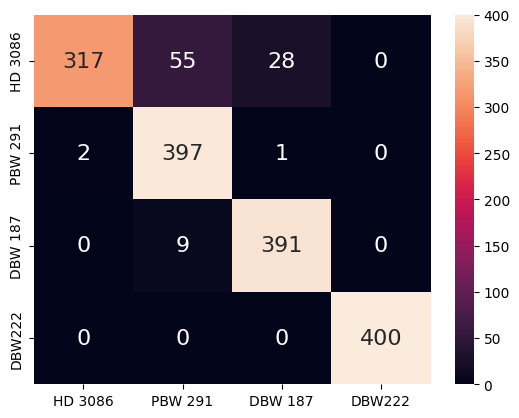

In [39]:
import seaborn as sn
import pandas as pd

df_cm = pd.DataFrame(cm,index =[i for i in VARIETIES],columns=[i for i in VARIETIES])
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16},fmt='.0f') # font size

plt.show()

In [40]:
last_epoch = 150

In [41]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 30, 30, 168  0           []                               
                                )]                                                                
                                                                                                  
 resizing (Resizing)            (None, 224, 224, 16  0           ['input_1[0][0]']                
                                8)                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  526912      ['resizing[0][0]']               
                                )                                                             

 max_pooling2d_6 (MaxPooling2D)  (None, 13, 13, 512)  0          ['tf.concat_2[0][0]']            
                                                                                                  
 conv2d_22 (Conv2D)             (None, 13, 13, 160)  82080       ['tf.concat_2[0][0]']            
                                                                                                  
 conv2d_24 (Conv2D)             (None, 13, 13, 224)  25312       ['conv2d_23[0][0]']              
                                                                                                  
 conv2d_26 (Conv2D)             (None, 13, 13, 64)   1600        ['conv2d_25[0][0]']              
                                                                                                  
 conv2d_27 (Conv2D)             (None, 13, 13, 64)   32832       ['max_pooling2d_6[0][0]']        
                                                                                                  
 tf.concat

                                                                                                  
 conv2d_49 (Conv2D)             (None, 6, 6, 320)    51520       ['conv2d_48[0][0]']              
                                                                                                  
 conv2d_51 (Conv2D)             (None, 6, 6, 128)    4224        ['conv2d_50[0][0]']              
                                                                                                  
 conv2d_52 (Conv2D)             (None, 6, 6, 128)    106624      ['max_pooling2d_11[0][0]']       
                                                                                                  
 tf.concat_7 (TFOpLambda)       (None, 6, 6, 832)    0           ['conv2d_47[0][0]',              
                                                                  'conv2d_49[0][0]',              
                                                                  'conv2d_51[0][0]',              
          

In [42]:
tic = start_timer()
while start_epoch<=last_epoch:
    print("\nEpoch: ",start_epoch)
    history = model.fit(x_train ,y_train ,batch_size=BATCH_SIZE ,epochs=1, verbose=2, validation_data=(x_val, y_val), shuffle=True)
    model.save('./GNmodels/'+str(start_epoch)+model_name)
    print("Model saved on epoch: ",start_epoch)
    
    history_dataframe = pd.DataFrame.from_dict(history.history)
    save_to_csv('./csvs/'+model_name+'.csv', history_dataframe, header=True)
    print("added to csv")
    start_epoch+=1
    
toc = end_timer()
show_time(tic,toc)

Testing started

Epoch:  101
75/75 - 49s - loss: 0.0837 - dense_4_loss: 0.0364 - dense_1_loss: 0.0984 - dense_3_loss: 0.0595 - dense_4_accuracy: 0.9900 - dense_1_accuracy: 0.9715 - dense_3_accuracy: 0.9812 - val_loss: 0.2837 - val_dense_4_loss: 0.1695 - val_dense_1_loss: 0.1764 - val_dense_3_loss: 0.2043 - val_dense_4_accuracy: 0.9388 - val_dense_1_accuracy: 0.9413 - val_dense_3_accuracy: 0.9287 - 49s/epoch - 658ms/step


2024-01-24 00:23:58.864193: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:23:58.873267: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:23:58.881421: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00

INFO:tensorflow:Assets written to: ./GNmodels/101GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/101GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  101
added to csv

Epoch:  102
75/75 - 49s - loss: 0.0896 - dense_4_loss: 0.0409 - dense_1_loss: 0.0979 - dense_3_loss: 0.0644 - dense_4_accuracy: 0.9850 - dense_1_accuracy: 0.9700 - dense_3_accuracy: 0.9769 - val_loss: 0.1695 - val_dense_4_loss: 0.0874 - val_dense_1_loss: 0.1484 - val_dense_3_loss: 0.1252 - val_dense_4_accuracy: 0.9762 - val_dense_1_accuracy: 0.9469 - val_dense_3_accuracy: 0.9625 - 49s/epoch - 658ms/step


2024-01-24 00:25:04.419513: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:25:04.428644: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:25:04.437284: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00

INFO:tensorflow:Assets written to: ./GNmodels/102GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/102GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  102
added to csv

Epoch:  103
75/75 - 50s - loss: 0.2223 - dense_4_loss: 0.1302 - dense_1_loss: 0.1640 - dense_3_loss: 0.1429 - dense_4_accuracy: 0.9654 - dense_1_accuracy: 0.9471 - dense_3_accuracy: 0.9546 - val_loss: 1.5405 - val_dense_4_loss: 0.8992 - val_dense_1_loss: 1.2070 - val_dense_3_loss: 0.9306 - val_dense_4_accuracy: 0.7050 - val_dense_1_accuracy: 0.6031 - val_dense_3_accuracy: 0.7050 - 50s/epoch - 662ms/step


2024-01-24 00:26:09.944994: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:26:09.954027: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:26:09.962255: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00

INFO:tensorflow:Assets written to: ./GNmodels/103GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/103GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  103
added to csv

Epoch:  104
75/75 - 49s - loss: 0.2473 - dense_4_loss: 0.1445 - dense_1_loss: 0.1798 - dense_3_loss: 0.1626 - dense_4_accuracy: 0.9579 - dense_1_accuracy: 0.9404 - dense_3_accuracy: 0.9540 - val_loss: 0.3244 - val_dense_4_loss: 0.1884 - val_dense_1_loss: 0.2370 - val_dense_3_loss: 0.2162 - val_dense_4_accuracy: 0.9350 - val_dense_1_accuracy: 0.9150 - val_dense_3_accuracy: 0.9275 - 49s/epoch - 657ms/step


2024-01-24 00:27:14.971736: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:27:14.980455: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:27:14.988590: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00

INFO:tensorflow:Assets written to: ./GNmodels/104GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/104GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  104
added to csv

Epoch:  105
75/75 - 49s - loss: 0.0480 - dense_4_loss: 0.0193 - dense_1_loss: 0.0617 - dense_3_loss: 0.0342 - dense_4_accuracy: 0.9956 - dense_1_accuracy: 0.9829 - dense_3_accuracy: 0.9908 - val_loss: 0.1262 - val_dense_4_loss: 0.0652 - val_dense_1_loss: 0.1149 - val_dense_3_loss: 0.0883 - val_dense_4_accuracy: 0.9825 - val_dense_1_accuracy: 0.9606 - val_dense_3_accuracy: 0.9719 - 49s/epoch - 658ms/step


2024-01-24 00:28:20.049064: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:28:20.058009: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:28:20.066452: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00

INFO:tensorflow:Assets written to: ./GNmodels/105GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/105GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  105
added to csv

Epoch:  106
75/75 - 49s - loss: 0.0347 - dense_4_loss: 0.0127 - dense_1_loss: 0.0488 - dense_3_loss: 0.0243 - dense_4_accuracy: 0.9979 - dense_1_accuracy: 0.9867 - dense_3_accuracy: 0.9935 - val_loss: 0.1108 - val_dense_4_loss: 0.0593 - val_dense_1_loss: 0.0926 - val_dense_3_loss: 0.0792 - val_dense_4_accuracy: 0.9800 - val_dense_1_accuracy: 0.9669 - val_dense_3_accuracy: 0.9731 - 49s/epoch - 655ms/step


2024-01-24 00:29:24.565511: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:29:24.574451: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:29:24.582546: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00

INFO:tensorflow:Assets written to: ./GNmodels/106GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/106GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  106
added to csv

Epoch:  107
75/75 - 49s - loss: 0.0441 - dense_4_loss: 0.0171 - dense_1_loss: 0.0585 - dense_3_loss: 0.0313 - dense_4_accuracy: 0.9940 - dense_1_accuracy: 0.9808 - dense_3_accuracy: 0.9894 - val_loss: 0.2369 - val_dense_4_loss: 0.1322 - val_dense_1_loss: 0.1930 - val_dense_3_loss: 0.1561 - val_dense_4_accuracy: 0.9638 - val_dense_1_accuracy: 0.9369 - val_dense_3_accuracy: 0.9550 - 49s/epoch - 657ms/step


2024-01-24 00:30:29.885311: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:30:29.895376: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:30:29.903633: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00

INFO:tensorflow:Assets written to: ./GNmodels/107GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/107GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  107
added to csv

Epoch:  108
75/75 - 49s - loss: 0.0507 - dense_4_loss: 0.0202 - dense_1_loss: 0.0652 - dense_3_loss: 0.0362 - dense_4_accuracy: 0.9935 - dense_1_accuracy: 0.9771 - dense_3_accuracy: 0.9885 - val_loss: 0.1019 - val_dense_4_loss: 0.0525 - val_dense_1_loss: 0.0921 - val_dense_3_loss: 0.0725 - val_dense_4_accuracy: 0.9856 - val_dense_1_accuracy: 0.9712 - val_dense_3_accuracy: 0.9775 - 49s/epoch - 659ms/step


2024-01-24 00:31:35.110525: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:31:35.119385: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:31:35.127576: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00

INFO:tensorflow:Assets written to: ./GNmodels/108GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/108GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  108
added to csv

Epoch:  109
75/75 - 49s - loss: 0.0278 - dense_4_loss: 0.0100 - dense_1_loss: 0.0415 - dense_3_loss: 0.0180 - dense_4_accuracy: 0.9977 - dense_1_accuracy: 0.9879 - dense_3_accuracy: 0.9948 - val_loss: 0.1070 - val_dense_4_loss: 0.0542 - val_dense_1_loss: 0.0921 - val_dense_3_loss: 0.0841 - val_dense_4_accuracy: 0.9831 - val_dense_1_accuracy: 0.9694 - val_dense_3_accuracy: 0.9750 - 49s/epoch - 658ms/step


2024-01-24 00:32:40.211691: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:32:40.220967: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:32:40.229440: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00

INFO:tensorflow:Assets written to: ./GNmodels/109GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/109GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  109
added to csv

Epoch:  110
75/75 - 50s - loss: 0.0465 - dense_4_loss: 0.0193 - dense_1_loss: 0.0558 - dense_3_loss: 0.0349 - dense_4_accuracy: 0.9927 - dense_1_accuracy: 0.9800 - dense_3_accuracy: 0.9885 - val_loss: 0.1282 - val_dense_4_loss: 0.0635 - val_dense_1_loss: 0.1074 - val_dense_3_loss: 0.1084 - val_dense_4_accuracy: 0.9831 - val_dense_1_accuracy: 0.9638 - val_dense_3_accuracy: 0.9675 - 50s/epoch - 662ms/step


2024-01-24 00:33:45.085328: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:33:45.093999: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:33:45.102041: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00

INFO:tensorflow:Assets written to: ./GNmodels/110GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/110GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  110
added to csv

Epoch:  111
75/75 - 49s - loss: 0.0233 - dense_4_loss: 0.0076 - dense_1_loss: 0.0360 - dense_3_loss: 0.0163 - dense_4_accuracy: 0.9983 - dense_1_accuracy: 0.9919 - dense_3_accuracy: 0.9956 - val_loss: 0.1570 - val_dense_4_loss: 0.0961 - val_dense_1_loss: 0.0883 - val_dense_3_loss: 0.1149 - val_dense_4_accuracy: 0.9756 - val_dense_1_accuracy: 0.9725 - val_dense_3_accuracy: 0.9675 - 49s/epoch - 660ms/step


2024-01-24 00:34:50.710033: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:34:50.718950: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:34:50.727071: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00

INFO:tensorflow:Assets written to: ./GNmodels/111GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/111GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  111
added to csv

Epoch:  112
75/75 - 49s - loss: 0.0128 - dense_4_loss: 0.0028 - dense_1_loss: 0.0246 - dense_3_loss: 0.0086 - dense_4_accuracy: 0.9996 - dense_1_accuracy: 0.9944 - dense_3_accuracy: 0.9983 - val_loss: 0.1504 - val_dense_4_loss: 0.0855 - val_dense_1_loss: 0.1115 - val_dense_3_loss: 0.1048 - val_dense_4_accuracy: 0.9781 - val_dense_1_accuracy: 0.9650 - val_dense_3_accuracy: 0.9719 - 49s/epoch - 659ms/step


2024-01-24 00:35:55.918023: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:35:55.926895: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:35:55.935092: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00

INFO:tensorflow:Assets written to: ./GNmodels/112GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/112GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  112
added to csv

Epoch:  113
75/75 - 49s - loss: 0.0107 - dense_4_loss: 0.0019 - dense_1_loss: 0.0215 - dense_3_loss: 0.0078 - dense_4_accuracy: 1.0000 - dense_1_accuracy: 0.9940 - dense_3_accuracy: 0.9981 - val_loss: 0.1030 - val_dense_4_loss: 0.0553 - val_dense_1_loss: 0.0804 - val_dense_3_loss: 0.0786 - val_dense_4_accuracy: 0.9862 - val_dense_1_accuracy: 0.9762 - val_dense_3_accuracy: 0.9787 - 49s/epoch - 658ms/step


2024-01-24 00:37:01.081493: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:37:01.090319: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:37:01.098408: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00

INFO:tensorflow:Assets written to: ./GNmodels/113GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/113GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  113
added to csv

Epoch:  114
75/75 - 49s - loss: 0.0093 - dense_4_loss: 0.0016 - dense_1_loss: 0.0208 - dense_3_loss: 0.0048 - dense_4_accuracy: 1.0000 - dense_1_accuracy: 0.9950 - dense_3_accuracy: 0.9994 - val_loss: 0.0957 - val_dense_4_loss: 0.0524 - val_dense_1_loss: 0.0710 - val_dense_3_loss: 0.0732 - val_dense_4_accuracy: 0.9862 - val_dense_1_accuracy: 0.9781 - val_dense_3_accuracy: 0.9787 - 49s/epoch - 659ms/step


2024-01-24 00:38:06.225144: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:38:06.234139: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:38:06.242350: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00

INFO:tensorflow:Assets written to: ./GNmodels/114GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/114GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  114
added to csv

Epoch:  115
75/75 - 48s - loss: 0.0077 - dense_4_loss: 0.0011 - dense_1_loss: 0.0178 - dense_3_loss: 0.0042 - dense_4_accuracy: 0.9998 - dense_1_accuracy: 0.9962 - dense_3_accuracy: 0.9990 - val_loss: 0.1039 - val_dense_4_loss: 0.0574 - val_dense_1_loss: 0.0755 - val_dense_3_loss: 0.0795 - val_dense_4_accuracy: 0.9881 - val_dense_1_accuracy: 0.9769 - val_dense_3_accuracy: 0.9794 - 48s/epoch - 646ms/step


2024-01-24 00:39:10.708042: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:39:10.718779: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:39:10.727690: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00

INFO:tensorflow:Assets written to: ./GNmodels/115GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/115GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  115
added to csv

Epoch:  116
75/75 - 48s - loss: 0.5419 - dense_4_loss: 0.3695 - dense_1_loss: 0.2700 - dense_3_loss: 0.3046 - dense_4_accuracy: 0.9287 - dense_1_accuracy: 0.9298 - dense_3_accuracy: 0.9312 - val_loss: 2.2834 - val_dense_4_loss: 1.4324 - val_dense_1_loss: 1.5003 - val_dense_3_loss: 1.3367 - val_dense_4_accuracy: 0.6800 - val_dense_1_accuracy: 0.6306 - val_dense_3_accuracy: 0.6662 - 48s/epoch - 644ms/step


2024-01-24 00:40:15.385006: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:40:15.394264: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:40:15.402850: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00

INFO:tensorflow:Assets written to: ./GNmodels/116GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/116GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  116
added to csv

Epoch:  117
75/75 - 49s - loss: 0.4655 - dense_4_loss: 0.2791 - dense_1_loss: 0.3318 - dense_3_loss: 0.2897 - dense_4_accuracy: 0.9129 - dense_1_accuracy: 0.8938 - dense_3_accuracy: 0.9044 - val_loss: 0.2143 - val_dense_4_loss: 0.1177 - val_dense_1_loss: 0.1781 - val_dense_3_loss: 0.1441 - val_dense_4_accuracy: 0.9644 - val_dense_1_accuracy: 0.9344 - val_dense_3_accuracy: 0.9531 - 49s/epoch - 648ms/step


2024-01-24 00:41:19.661356: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:41:19.670205: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:41:19.678640: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00

INFO:tensorflow:Assets written to: ./GNmodels/117GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/117GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  117
added to csv

Epoch:  118
75/75 - 48s - loss: 0.0829 - dense_4_loss: 0.0440 - dense_1_loss: 0.0715 - dense_3_loss: 0.0582 - dense_4_accuracy: 0.9883 - dense_1_accuracy: 0.9769 - dense_3_accuracy: 0.9819 - val_loss: 0.1054 - val_dense_4_loss: 0.0521 - val_dense_1_loss: 0.0987 - val_dense_3_loss: 0.0789 - val_dense_4_accuracy: 0.9825 - val_dense_1_accuracy: 0.9650 - val_dense_3_accuracy: 0.9744 - 48s/epoch - 646ms/step


2024-01-24 00:42:24.406584: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:42:24.415808: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:42:24.424385: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00

INFO:tensorflow:Assets written to: ./GNmodels/118GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/118GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  118
added to csv

Epoch:  119
75/75 - 49s - loss: 0.0351 - dense_4_loss: 0.0167 - dense_1_loss: 0.0370 - dense_3_loss: 0.0246 - dense_4_accuracy: 0.9969 - dense_1_accuracy: 0.9900 - dense_3_accuracy: 0.9940 - val_loss: 0.0917 - val_dense_4_loss: 0.0445 - val_dense_1_loss: 0.0860 - val_dense_3_loss: 0.0711 - val_dense_4_accuracy: 0.9837 - val_dense_1_accuracy: 0.9706 - val_dense_3_accuracy: 0.9762 - 49s/epoch - 650ms/step


2024-01-24 00:43:29.154856: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:43:29.164460: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:43:29.172851: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00

INFO:tensorflow:Assets written to: ./GNmodels/119GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/119GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  119
added to csv

Epoch:  120
75/75 - 49s - loss: 0.0233 - dense_4_loss: 0.0103 - dense_1_loss: 0.0278 - dense_3_loss: 0.0156 - dense_4_accuracy: 0.9983 - dense_1_accuracy: 0.9925 - dense_3_accuracy: 0.9969 - val_loss: 0.1132 - val_dense_4_loss: 0.0631 - val_dense_1_loss: 0.0756 - val_dense_3_loss: 0.0914 - val_dense_4_accuracy: 0.9781 - val_dense_1_accuracy: 0.9750 - val_dense_3_accuracy: 0.9712 - 49s/epoch - 653ms/step


2024-01-24 00:44:34.133695: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:44:34.142599: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:44:34.151955: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00

INFO:tensorflow:Assets written to: ./GNmodels/120GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/120GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  120
added to csv

Epoch:  121
75/75 - 49s - loss: 0.0126 - dense_4_loss: 0.0041 - dense_1_loss: 0.0200 - dense_3_loss: 0.0083 - dense_4_accuracy: 0.9998 - dense_1_accuracy: 0.9946 - dense_3_accuracy: 0.9990 - val_loss: 0.1409 - val_dense_4_loss: 0.0816 - val_dense_1_loss: 0.1009 - val_dense_3_loss: 0.0970 - val_dense_4_accuracy: 0.9775 - val_dense_1_accuracy: 0.9700 - val_dense_3_accuracy: 0.9700 - 49s/epoch - 649ms/step


2024-01-24 00:45:38.684828: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:45:38.694072: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:45:38.702673: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00

INFO:tensorflow:Assets written to: ./GNmodels/121GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/121GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  121
added to csv

Epoch:  122
75/75 - 49s - loss: 0.0114 - dense_4_loss: 0.0037 - dense_1_loss: 0.0178 - dense_3_loss: 0.0078 - dense_4_accuracy: 0.9996 - dense_1_accuracy: 0.9969 - dense_3_accuracy: 0.9990 - val_loss: 0.1285 - val_dense_4_loss: 0.0744 - val_dense_1_loss: 0.0860 - val_dense_3_loss: 0.0943 - val_dense_4_accuracy: 0.9775 - val_dense_1_accuracy: 0.9719 - val_dense_3_accuracy: 0.9731 - 49s/epoch - 647ms/step


2024-01-24 00:46:42.553701: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:46:42.562679: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:46:42.570840: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00

INFO:tensorflow:Assets written to: ./GNmodels/122GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/122GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  122
added to csv

Epoch:  123
75/75 - 48s - loss: 0.0141 - dense_4_loss: 0.0049 - dense_1_loss: 0.0207 - dense_3_loss: 0.0099 - dense_4_accuracy: 0.9990 - dense_1_accuracy: 0.9940 - dense_3_accuracy: 0.9973 - val_loss: 0.1175 - val_dense_4_loss: 0.0682 - val_dense_1_loss: 0.0757 - val_dense_3_loss: 0.0887 - val_dense_4_accuracy: 0.9775 - val_dense_1_accuracy: 0.9769 - val_dense_3_accuracy: 0.9737 - 48s/epoch - 644ms/step


2024-01-24 00:47:46.939060: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:47:46.948010: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:47:46.956378: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00

INFO:tensorflow:Assets written to: ./GNmodels/123GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/123GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  123
added to csv

Epoch:  124
75/75 - 48s - loss: 0.0124 - dense_4_loss: 0.0038 - dense_1_loss: 0.0201 - dense_3_loss: 0.0088 - dense_4_accuracy: 0.9992 - dense_1_accuracy: 0.9937 - dense_3_accuracy: 0.9967 - val_loss: 0.1071 - val_dense_4_loss: 0.0599 - val_dense_1_loss: 0.0828 - val_dense_3_loss: 0.0745 - val_dense_4_accuracy: 0.9825 - val_dense_1_accuracy: 0.9762 - val_dense_3_accuracy: 0.9800 - 48s/epoch - 646ms/step


2024-01-24 00:48:51.250005: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:48:51.259273: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:48:51.267691: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00

INFO:tensorflow:Assets written to: ./GNmodels/124GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/124GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  124
added to csv

Epoch:  125
75/75 - 49s - loss: 0.0145 - dense_4_loss: 0.0056 - dense_1_loss: 0.0206 - dense_3_loss: 0.0091 - dense_4_accuracy: 0.9985 - dense_1_accuracy: 0.9940 - dense_3_accuracy: 0.9971 - val_loss: 0.0965 - val_dense_4_loss: 0.0492 - val_dense_1_loss: 0.0779 - val_dense_3_loss: 0.0799 - val_dense_4_accuracy: 0.9850 - val_dense_1_accuracy: 0.9756 - val_dense_3_accuracy: 0.9806 - 49s/epoch - 647ms/step


2024-01-24 00:49:55.632126: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:49:55.641610: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:49:55.650001: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00

INFO:tensorflow:Assets written to: ./GNmodels/125GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/125GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  125
added to csv

Epoch:  126
75/75 - 48s - loss: 0.0096 - dense_4_loss: 0.0027 - dense_1_loss: 0.0165 - dense_3_loss: 0.0062 - dense_4_accuracy: 0.9996 - dense_1_accuracy: 0.9952 - dense_3_accuracy: 0.9983 - val_loss: 0.1510 - val_dense_4_loss: 0.0821 - val_dense_1_loss: 0.1291 - val_dense_3_loss: 0.1008 - val_dense_4_accuracy: 0.9794 - val_dense_1_accuracy: 0.9613 - val_dense_3_accuracy: 0.9737 - 48s/epoch - 645ms/step


2024-01-24 00:50:59.427703: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:50:59.437549: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:50:59.848064: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00

INFO:tensorflow:Assets written to: ./GNmodels/126GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/126GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  126
added to csv

Epoch:  127
75/75 - 48s - loss: 0.0062 - dense_4_loss: 0.0013 - dense_1_loss: 0.0130 - dense_3_loss: 0.0032 - dense_4_accuracy: 0.9998 - dense_1_accuracy: 0.9967 - dense_3_accuracy: 0.9994 - val_loss: 0.0707 - val_dense_4_loss: 0.0344 - val_dense_1_loss: 0.0653 - val_dense_3_loss: 0.0558 - val_dense_4_accuracy: 0.9912 - val_dense_1_accuracy: 0.9800 - val_dense_3_accuracy: 0.9844 - 48s/epoch - 645ms/step


2024-01-24 00:52:03.643612: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:52:03.652872: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:52:03.661130: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00

INFO:tensorflow:Assets written to: ./GNmodels/127GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/127GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  127
added to csv

Epoch:  128
75/75 - 49s - loss: 0.0058 - dense_4_loss: 0.0012 - dense_1_loss: 0.0123 - dense_3_loss: 0.0030 - dense_4_accuracy: 1.0000 - dense_1_accuracy: 0.9967 - dense_3_accuracy: 0.9996 - val_loss: 0.1160 - val_dense_4_loss: 0.0638 - val_dense_1_loss: 0.0894 - val_dense_3_loss: 0.0845 - val_dense_4_accuracy: 0.9856 - val_dense_1_accuracy: 0.9706 - val_dense_3_accuracy: 0.9762 - 49s/epoch - 647ms/step


2024-01-24 00:53:08.359260: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:53:08.368417: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:53:08.376741: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00

INFO:tensorflow:Assets written to: ./GNmodels/128GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/128GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  128
added to csv

Epoch:  129
75/75 - 48s - loss: 0.0072 - dense_4_loss: 0.0017 - dense_1_loss: 0.0151 - dense_3_loss: 0.0031 - dense_4_accuracy: 0.9996 - dense_1_accuracy: 0.9960 - dense_3_accuracy: 0.9998 - val_loss: 0.2202 - val_dense_4_loss: 0.1328 - val_dense_1_loss: 0.1438 - val_dense_3_loss: 0.1478 - val_dense_4_accuracy: 0.9656 - val_dense_1_accuracy: 0.9606 - val_dense_3_accuracy: 0.9619 - 48s/epoch - 644ms/step


2024-01-24 00:54:12.562055: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:54:12.571279: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:54:12.580623: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00

INFO:tensorflow:Assets written to: ./GNmodels/129GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/129GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  129
added to csv

Epoch:  130
75/75 - 48s - loss: 1.5649 - dense_4_loss: 0.9739 - dense_1_loss: 0.9544 - dense_3_loss: 1.0154 - dense_4_accuracy: 0.8087 - dense_1_accuracy: 0.8102 - dense_3_accuracy: 0.8119 - val_loss: 1.9083 - val_dense_4_loss: 1.1908 - val_dense_1_loss: 1.2240 - val_dense_3_loss: 1.1678 - val_dense_4_accuracy: 0.4244 - val_dense_1_accuracy: 0.4100 - val_dense_3_accuracy: 0.5481 - 48s/epoch - 643ms/step


2024-01-24 00:55:16.187535: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:55:16.196540: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:55:16.204792: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00

INFO:tensorflow:Assets written to: ./GNmodels/130GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/130GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  130
added to csv

Epoch:  131
75/75 - 48s - loss: 1.2575 - dense_4_loss: 0.7806 - dense_1_loss: 0.8079 - dense_3_loss: 0.7817 - dense_4_accuracy: 0.7123 - dense_1_accuracy: 0.6898 - dense_3_accuracy: 0.6921 - val_loss: 0.9308 - val_dense_4_loss: 0.5644 - val_dense_1_loss: 0.5871 - val_dense_3_loss: 0.6344 - val_dense_4_accuracy: 0.7975 - val_dense_1_accuracy: 0.8037 - val_dense_3_accuracy: 0.7281 - 48s/epoch - 645ms/step


2024-01-24 00:56:20.574792: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:56:20.583784: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:56:20.592367: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00

INFO:tensorflow:Assets written to: ./GNmodels/131GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/131GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  131
added to csv

Epoch:  132
75/75 - 49s - loss: 0.5441 - dense_4_loss: 0.3164 - dense_1_loss: 0.3630 - dense_3_loss: 0.3960 - dense_4_accuracy: 0.8813 - dense_1_accuracy: 0.8813 - dense_3_accuracy: 0.8473 - val_loss: 0.4797 - val_dense_4_loss: 0.2811 - val_dense_1_loss: 0.3248 - val_dense_3_loss: 0.3372 - val_dense_4_accuracy: 0.9069 - val_dense_1_accuracy: 0.9050 - val_dense_3_accuracy: 0.9050 - 49s/epoch - 647ms/step


2024-01-24 00:57:25.221076: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:57:25.230110: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:57:25.239510: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00

INFO:tensorflow:Assets written to: ./GNmodels/132GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/132GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  132
added to csv

Epoch:  133
75/75 - 48s - loss: 0.2517 - dense_4_loss: 0.1390 - dense_1_loss: 0.1912 - dense_3_loss: 0.1845 - dense_4_accuracy: 0.9498 - dense_1_accuracy: 0.9394 - dense_3_accuracy: 0.9392 - val_loss: 0.4091 - val_dense_4_loss: 0.2400 - val_dense_1_loss: 0.2938 - val_dense_3_loss: 0.2699 - val_dense_4_accuracy: 0.9181 - val_dense_1_accuracy: 0.9056 - val_dense_3_accuracy: 0.9081 - 48s/epoch - 646ms/step


2024-01-24 00:58:29.346650: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:58:29.356048: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:58:29.364567: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00

INFO:tensorflow:Assets written to: ./GNmodels/133GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/133GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  133
added to csv

Epoch:  134
75/75 - 48s - loss: 0.0890 - dense_4_loss: 0.0412 - dense_1_loss: 0.0961 - dense_3_loss: 0.0630 - dense_4_accuracy: 0.9873 - dense_1_accuracy: 0.9696 - dense_3_accuracy: 0.9804 - val_loss: 0.2294 - val_dense_4_loss: 0.1302 - val_dense_1_loss: 0.1686 - val_dense_3_loss: 0.1622 - val_dense_4_accuracy: 0.9613 - val_dense_1_accuracy: 0.9475 - val_dense_3_accuracy: 0.9481 - 48s/epoch - 646ms/step


2024-01-24 00:59:33.202006: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:59:33.210955: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00:59:33.219324: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 00

INFO:tensorflow:Assets written to: ./GNmodels/134GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/134GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  134
added to csv

Epoch:  135
75/75 - 48s - loss: 0.0691 - dense_4_loss: 0.0327 - dense_1_loss: 0.0733 - dense_3_loss: 0.0480 - dense_4_accuracy: 0.9896 - dense_1_accuracy: 0.9765 - dense_3_accuracy: 0.9833 - val_loss: 0.2268 - val_dense_4_loss: 0.1234 - val_dense_1_loss: 0.1715 - val_dense_3_loss: 0.1730 - val_dense_4_accuracy: 0.9650 - val_dense_1_accuracy: 0.9413 - val_dense_3_accuracy: 0.9450 - 48s/epoch - 642ms/step


2024-01-24 01:00:37.394580: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 01:00:37.403674: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 01:00:37.411943: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 01

INFO:tensorflow:Assets written to: ./GNmodels/135GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/135GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  135
added to csv

Epoch:  136
75/75 - 49s - loss: 0.0636 - dense_4_loss: 0.0298 - dense_1_loss: 0.0669 - dense_3_loss: 0.0457 - dense_4_accuracy: 0.9902 - dense_1_accuracy: 0.9771 - dense_3_accuracy: 0.9848 - val_loss: 0.0996 - val_dense_4_loss: 0.0478 - val_dense_1_loss: 0.0952 - val_dense_3_loss: 0.0776 - val_dense_4_accuracy: 0.9862 - val_dense_1_accuracy: 0.9688 - val_dense_3_accuracy: 0.9731 - 49s/epoch - 658ms/step


2024-01-24 01:01:42.730470: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 01:01:42.739480: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 01:01:42.747727: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 01

INFO:tensorflow:Assets written to: ./GNmodels/136GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/136GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  136
added to csv

Epoch:  137
75/75 - 48s - loss: 0.1019 - dense_4_loss: 0.0535 - dense_1_loss: 0.0909 - dense_3_loss: 0.0704 - dense_4_accuracy: 0.9808 - dense_1_accuracy: 0.9685 - dense_3_accuracy: 0.9750 - val_loss: 0.1128 - val_dense_4_loss: 0.0543 - val_dense_1_loss: 0.1060 - val_dense_3_loss: 0.0887 - val_dense_4_accuracy: 0.9862 - val_dense_1_accuracy: 0.9663 - val_dense_3_accuracy: 0.9756 - 48s/epoch - 645ms/step


2024-01-24 01:02:46.910525: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 01:02:46.919760: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 01:02:46.928236: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 01

INFO:tensorflow:Assets written to: ./GNmodels/137GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/137GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  137
added to csv

Epoch:  138
75/75 - 48s - loss: 0.0251 - dense_4_loss: 0.0094 - dense_1_loss: 0.0346 - dense_3_loss: 0.0179 - dense_4_accuracy: 0.9977 - dense_1_accuracy: 0.9904 - dense_3_accuracy: 0.9960 - val_loss: 0.0961 - val_dense_4_loss: 0.0511 - val_dense_1_loss: 0.0726 - val_dense_3_loss: 0.0774 - val_dense_4_accuracy: 0.9825 - val_dense_1_accuracy: 0.9744 - val_dense_3_accuracy: 0.9744 - 48s/epoch - 646ms/step


2024-01-24 01:03:50.648916: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 01:03:50.658788: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 01:03:51.073569: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 01

INFO:tensorflow:Assets written to: ./GNmodels/138GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/138GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  138
added to csv

Epoch:  139
75/75 - 49s - loss: 0.0665 - dense_4_loss: 0.0318 - dense_1_loss: 0.0681 - dense_3_loss: 0.0477 - dense_4_accuracy: 0.9885 - dense_1_accuracy: 0.9758 - dense_3_accuracy: 0.9831 - val_loss: 0.1410 - val_dense_4_loss: 0.0717 - val_dense_1_loss: 0.1243 - val_dense_3_loss: 0.1066 - val_dense_4_accuracy: 0.9794 - val_dense_1_accuracy: 0.9600 - val_dense_3_accuracy: 0.9675 - 49s/epoch - 647ms/step


2024-01-24 01:04:55.140719: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 01:04:55.149853: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 01:04:55.158017: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 01

INFO:tensorflow:Assets written to: ./GNmodels/139GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/139GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  139
added to csv

Epoch:  140
75/75 - 49s - loss: 0.6374 - dense_4_loss: 0.4121 - dense_1_loss: 0.3897 - dense_3_loss: 0.3613 - dense_4_accuracy: 0.9135 - dense_1_accuracy: 0.9067 - dense_3_accuracy: 0.9108 - val_loss: 1.3362 - val_dense_4_loss: 0.8727 - val_dense_1_loss: 0.9606 - val_dense_3_loss: 0.5844 - val_dense_4_accuracy: 0.7056 - val_dense_1_accuracy: 0.7244 - val_dense_3_accuracy: 0.7431 - 49s/epoch - 649ms/step


2024-01-24 01:06:00.018223: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 01:06:00.027434: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 01:06:00.035952: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 01

INFO:tensorflow:Assets written to: ./GNmodels/140GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/140GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  140
added to csv

Epoch:  141
75/75 - 48s - loss: 0.2678 - dense_4_loss: 0.1700 - dense_1_loss: 0.1666 - dense_3_loss: 0.1594 - dense_4_accuracy: 0.9533 - dense_1_accuracy: 0.9577 - dense_3_accuracy: 0.9610 - val_loss: 0.1577 - val_dense_4_loss: 0.0825 - val_dense_1_loss: 0.1428 - val_dense_3_loss: 0.1080 - val_dense_4_accuracy: 0.9781 - val_dense_1_accuracy: 0.9581 - val_dense_3_accuracy: 0.9656 - 48s/epoch - 646ms/step


2024-01-24 01:07:04.309730: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 01:07:04.318682: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 01:07:04.328015: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 01

INFO:tensorflow:Assets written to: ./GNmodels/141GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/141GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  141
added to csv

Epoch:  142
75/75 - 48s - loss: 0.0459 - dense_4_loss: 0.0239 - dense_1_loss: 0.0447 - dense_3_loss: 0.0287 - dense_4_accuracy: 0.9956 - dense_1_accuracy: 0.9881 - dense_3_accuracy: 0.9925 - val_loss: 0.1383 - val_dense_4_loss: 0.0708 - val_dense_1_loss: 0.1256 - val_dense_3_loss: 0.0996 - val_dense_4_accuracy: 0.9725 - val_dense_1_accuracy: 0.9600 - val_dense_3_accuracy: 0.9663 - 48s/epoch - 642ms/step


2024-01-24 01:08:07.985712: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 01:08:07.995236: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 01:08:08.003532: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 01

INFO:tensorflow:Assets written to: ./GNmodels/142GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/142GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  142
added to csv

Epoch:  143
75/75 - 49s - loss: 0.0249 - dense_4_loss: 0.0111 - dense_1_loss: 0.0293 - dense_3_loss: 0.0166 - dense_4_accuracy: 0.9985 - dense_1_accuracy: 0.9908 - dense_3_accuracy: 0.9962 - val_loss: 0.1270 - val_dense_4_loss: 0.0636 - val_dense_1_loss: 0.1148 - val_dense_3_loss: 0.0965 - val_dense_4_accuracy: 0.9812 - val_dense_1_accuracy: 0.9656 - val_dense_3_accuracy: 0.9688 - 49s/epoch - 649ms/step


2024-01-24 01:09:12.680404: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 01:09:12.689765: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 01:09:12.698042: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 01

INFO:tensorflow:Assets written to: ./GNmodels/143GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/143GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  143
added to csv

Epoch:  144
75/75 - 48s - loss: 0.0172 - dense_4_loss: 0.0064 - dense_1_loss: 0.0245 - dense_3_loss: 0.0114 - dense_4_accuracy: 0.9994 - dense_1_accuracy: 0.9933 - dense_3_accuracy: 0.9985 - val_loss: 0.1081 - val_dense_4_loss: 0.0545 - val_dense_1_loss: 0.0981 - val_dense_3_loss: 0.0804 - val_dense_4_accuracy: 0.9844 - val_dense_1_accuracy: 0.9694 - val_dense_3_accuracy: 0.9731 - 48s/epoch - 644ms/step


2024-01-24 01:10:17.278750: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 01:10:17.287840: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 01:10:17.297329: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 01

INFO:tensorflow:Assets written to: ./GNmodels/144GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/144GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  144
added to csv

Epoch:  145
75/75 - 48s - loss: 0.0148 - dense_4_loss: 0.0058 - dense_1_loss: 0.0204 - dense_3_loss: 0.0094 - dense_4_accuracy: 0.9990 - dense_1_accuracy: 0.9948 - dense_3_accuracy: 0.9977 - val_loss: 0.1121 - val_dense_4_loss: 0.0602 - val_dense_1_loss: 0.0845 - val_dense_3_loss: 0.0886 - val_dense_4_accuracy: 0.9837 - val_dense_1_accuracy: 0.9725 - val_dense_3_accuracy: 0.9706 - 48s/epoch - 647ms/step


2024-01-24 01:11:21.591612: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 01:11:21.600830: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 01:11:21.609798: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 01

INFO:tensorflow:Assets written to: ./GNmodels/145GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/145GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  145
added to csv

Epoch:  146
75/75 - 49s - loss: 0.0118 - dense_4_loss: 0.0040 - dense_1_loss: 0.0183 - dense_3_loss: 0.0077 - dense_4_accuracy: 0.9998 - dense_1_accuracy: 0.9952 - dense_3_accuracy: 0.9985 - val_loss: 0.0905 - val_dense_4_loss: 0.0430 - val_dense_1_loss: 0.0900 - val_dense_3_loss: 0.0682 - val_dense_4_accuracy: 0.9869 - val_dense_1_accuracy: 0.9688 - val_dense_3_accuracy: 0.9775 - 49s/epoch - 647ms/step


2024-01-24 01:12:25.577085: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 01:12:25.586550: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 01:12:25.594928: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 01

INFO:tensorflow:Assets written to: ./GNmodels/146GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/146GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  146
added to csv

Epoch:  147
75/75 - 49s - loss: 0.0123 - dense_4_loss: 0.0045 - dense_1_loss: 0.0171 - dense_3_loss: 0.0088 - dense_4_accuracy: 0.9992 - dense_1_accuracy: 0.9960 - dense_3_accuracy: 0.9967 - val_loss: 0.1039 - val_dense_4_loss: 0.0592 - val_dense_1_loss: 0.0728 - val_dense_3_loss: 0.0762 - val_dense_4_accuracy: 0.9850 - val_dense_1_accuracy: 0.9756 - val_dense_3_accuracy: 0.9787 - 49s/epoch - 647ms/step


2024-01-24 01:13:30.188366: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 01:13:30.197761: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 01:13:30.206243: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 01

INFO:tensorflow:Assets written to: ./GNmodels/147GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/147GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  147
added to csv

Epoch:  148
75/75 - 49s - loss: 0.0080 - dense_4_loss: 0.0021 - dense_1_loss: 0.0147 - dense_3_loss: 0.0050 - dense_4_accuracy: 1.0000 - dense_1_accuracy: 0.9956 - dense_3_accuracy: 0.9992 - val_loss: 0.0664 - val_dense_4_loss: 0.0308 - val_dense_1_loss: 0.0652 - val_dense_3_loss: 0.0534 - val_dense_4_accuracy: 0.9900 - val_dense_1_accuracy: 0.9806 - val_dense_3_accuracy: 0.9856 - 49s/epoch - 647ms/step


2024-01-24 01:14:34.607410: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 01:14:34.616669: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 01:14:34.625100: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 01

INFO:tensorflow:Assets written to: ./GNmodels/148GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/148GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  148
added to csv

Epoch:  149
75/75 - 49s - loss: 0.0086 - dense_4_loss: 0.0024 - dense_1_loss: 0.0149 - dense_3_loss: 0.0060 - dense_4_accuracy: 1.0000 - dense_1_accuracy: 0.9965 - dense_3_accuracy: 0.9983 - val_loss: 0.1846 - val_dense_4_loss: 0.1008 - val_dense_1_loss: 0.1300 - val_dense_3_loss: 0.1494 - val_dense_4_accuracy: 0.9719 - val_dense_1_accuracy: 0.9581 - val_dense_3_accuracy: 0.9556 - 49s/epoch - 647ms/step


2024-01-24 01:15:39.106257: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 01:15:39.115681: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 01:15:39.124322: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 01

INFO:tensorflow:Assets written to: ./GNmodels/149GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/149GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  149
added to csv

Epoch:  150
75/75 - 49s - loss: 0.0099 - dense_4_loss: 0.0032 - dense_1_loss: 0.0161 - dense_3_loss: 0.0063 - dense_4_accuracy: 0.9994 - dense_1_accuracy: 0.9956 - dense_3_accuracy: 0.9987 - val_loss: 0.0704 - val_dense_4_loss: 0.0327 - val_dense_1_loss: 0.0674 - val_dense_3_loss: 0.0580 - val_dense_4_accuracy: 0.9900 - val_dense_1_accuracy: 0.9769 - val_dense_3_accuracy: 0.9850 - 49s/epoch - 649ms/step


2024-01-24 01:16:43.214863: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 01:16:43.225128: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 01:16:43.651405: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2024-01-24 01

INFO:tensorflow:Assets written to: ./GNmodels/150GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/150GN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  150
added to csv
Testing time (s) = 3229.642299544008



In [43]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y_pred = model.predict(test_dataset)

50/50 [==============================] - 6s 115ms/step


In [44]:
y_pred_labels = np.argmax(y_pred, axis=2)

In [45]:
for y_pred_label in y_pred_labels:
    # Calculate accuracy
    accuracy = accuracy_score(test_dataset_label, y_pred_label)
    print("Accuracy:", accuracy)
    
    # Calculate confusion matrix
    cm = confusion_matrix(test_dataset_label, y_pred_label)
    print("Confusion Matrix:")
    print(cm)
    
    # Calculate precision, recall, and F1-score for each class
    print("Classification Report:")
    print(classification_report(test_dataset_label, y_pred_label))

Accuracy: 0.989375
Confusion Matrix:
[[386   2  12   0]
 [  0 399   1   0]
 [  0   2 398   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       400
           1       0.99      1.00      0.99       400
           2       0.97      0.99      0.98       400
           3       1.00      1.00      1.00       400

    accuracy                           0.99      1600
   macro avg       0.99      0.99      0.99      1600
weighted avg       0.99      0.99      0.99      1600

Accuracy: 0.98375
Confusion Matrix:
[[385   3  12   0]
 [  1 393   6   0]
 [  0   4 396   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       400
           1       0.98      0.98      0.98       400
           2       0.96      0.99      0.97       400
           3       1.00      1.00      1.00       400

    accuracy        

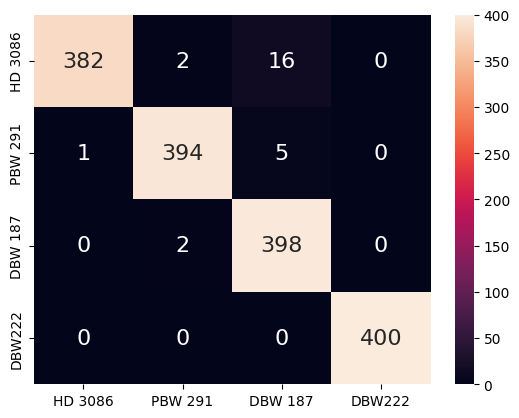

In [46]:
import seaborn as sn
import pandas as pd

df_cm = pd.DataFrame(cm,index =[i for i in VARIETIES],columns=[i for i in VARIETIES])
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16},fmt='.0f') # font size

plt.show()